# 0. IMPORTS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math
import random
import pickle
import json
import datetime as datetime

from scipy import stats
from IPython.display import Image
from IPython.display import HTML
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb

## 0.1 Helper functions

In [3]:
def time_series_cross_validation(kfold, training_set, model_name, model, verbose=False):
    '''
    kfold: quantity of folds
    training_set: traning set
    model_name: label, name of the model
    model: the model with its parameters
    verbose: print a message for every new kfold iteration
    '''
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in range(kfold,0,-1):
        if verbose:
            print(f'Kfold: {k}...')
        
        # start and end date for validation
        validation_start_date = training_set['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = training_set['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # date filter
        training = training_set[(training_set['date'] < validation_start_date)]
        validation = training_set[(training_set['date'] >= validation_start_date) & (training_set['date'] <= validation_end_date)]

        # dataset construction for cross validation
        # for training
        x_training = training.drop(['date','sales'], axis=1)
        y_training = training['sales']
        # for validation
        x_validation = validation.drop(['date','sales'], axis=1)
        y_validation = validation['sales']

        # model
        m = model.fit(x_training,y_training)

        # prediction
        yhat = m.predict(x_validation)

        # performance
        m_result = ml_error('label',np.expm1(y_validation),np.expm1(yhat))

        # store the result for iteration of k
        mae_list.append(m_result['MAE'].values)
        mape_list.append(m_result['MAPE_manual'].values)
        rmse_list.append(m_result['RMSE'].values)
        
    return pd.DataFrame(index=[model_name], 
                        data={'MAE': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                              'MAPE_manual': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                              'RMSE': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)})

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def mean_absolute_percentage_error_manual(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape_manual = mean_absolute_percentage_error_manual(y, yhat)
    mape_sklearn = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame(index=[model_name], data= {'MAE':mae,
                                                 'MAPE_manual':mape_manual,
                                                 'MAPE_sklearn':mape_sklearn,
                                                 'RMSE':rmse})

def cramer_v(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    # é necessário os valores da cm como uma matriz
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 =stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
   # for pandas to display the complete dataframe, with no restriction on the number of columns to be displayed, I can change the following option:
    pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

## 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store' )

In [6]:
df_raw.sample(20).T

,338631,298825,272234,49350,619798,499974,816993,580155,471327,726965,836365,866733,278253,20995,471406,283953,226772,613874,344509,604608
Store,400,880,387,291,644,125,484,26,468,771,901,49,877,926,547,984,428,295,729,1064
DayOfWeek,6,7,7,3,1,3,6,1,1,3,3,3,1,1,1,2,5,6,7,1
Date,2014-09-13,2014-10-26,2014-11-23,2015-06-17,2013-12-23,2014-04-09,2013-06-29,2014-01-27,2014-05-05,2013-09-18,2013-06-12,2013-05-15,2014-11-17,2015-07-13,2014-05-05,2014-11-11,2015-01-09,2013-12-28,2014-09-07,2014-01-06
Sales,5421,0,0,9400,18682,9778,8483,3978,7386,4914,5768,7310,6200,8927,7893,6425,6865,3915,0,12604
Customers,836,0,0,892,2142,1370,871,394,722,566,568,503,875,585,531,732,549,518,0,1354
Open,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
Promo,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,1,0,0,1
StateHoliday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SchoolHoliday,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
StoreType,a,a,c,d,c,a,a,d,c,a,a,d,a,d,d,c,d,a,c,a


# 1.0. DATA DESCRIPTION

In [7]:
# it's good to copy the df at the beginning of each section to avoid that, if you change the df content, you don't have to run all the code again
df1 = df_raw.copy()

## 1.1 Rename columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data dimensions

In [9]:
# print the number of rows and columns using 2 ways to interpolate strings
print(f'Number of Rows: {df1.shape[0]}')
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data types

In [10]:
# initially date is object
# must change the date type
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

There are 3 main methods:
- Remove all lines with NA: method has the huge disadvantage of losing a lot of information <br>
- Use some algorithm to fill in the NA data, such as mean, median or some ML to estimate values <br>
- Understand the reason why it is NA; it is always recommended start with this method, as eventually NA was a expect value for the feature
    

In [12]:
#competition_distance: distance in meters to the nearest competitor store

# the code below reveals that there are 3 stores (622, 291 and 879) that have this column blank
stores = df1[df1["competition_distance"].isna()]["store"].value_counts()
display(stores)
print("\n")

# the code below reveals that there are the same number of lines that bring data from these stores in relation to the number of lines with the nearest competitor distance value equal to NA. 
# thus, it is concluded that all lines of these 3 stores are, in fact, with the NA value for competition_distance
for store in stores.index:
    print(df1[df1["store"] == store].shape[0])
print("\n")  
    
# therefore, it is reasonable to assume that this NA value for the competition distance means that there is no competing store nearby. 
# it will then be replaced by a value much greater than the maximum distance.
# however, first we need to know the maximum distance present in the dataset
print((df1["competition_distance"].max()))
print("\n") 

# knowing that the maximum distance is 75860, we can substitute 200,000, for example
df1["competition_distance"] = df1["competition_distance"].fillna(200000)

# finally, checking if assigned correctly
print("After modification, now there is " + str(df1["competition_distance"].isna().sum()) + " missing value(s).")

622    942
291    942
879    758
Name: store, dtype: int64



942
942
758


75860.0


After modification, now there is 0 missing value(s).


In [13]:
# competition_open_since_month:  gives the approximate year and month of the time the nearest competitor was opened

# for the first CRISP interaction, for those stores where I don't have the information about when the competing store opened,
# I will simply allocate the same sales line month. Even though it is not logical, if necessary in the second interaction of the CRISP method I can change this assignment.
# one reason for this assumption is that the month and year a competing store opened can signify an event in sales behavior.
# therefore, if the month and year of the competing store "follows" the month and year of the date of sale, there will be no effect on sales for the lines that initially were NA.

x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
df1["competition_open_since_month"] = df1.apply(x, axis=1)

# the same reasoning for "competition_open_since_month" goes for "competition_open_since_year", promo2_since_week and promo2_since_year
# competition_open_since_year
x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
df1["competition_open_since_year"] = df1.apply(x, axis=1)

# promo2_since_week
x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
df1["promo2_since_week"] = df1.apply(x, axis=1)

# promo2_since_year
x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
df1["promo2_since_year"] = df1.apply(x, axis=1)


In [14]:
# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
# example: "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# for the first round of CRISP, the value 0 (zero) will be assigned to the missing data of the column "promo_interval"
df1["promo_interval"].fillna(0, inplace = True)

# next, it will be checked if the month of the row date is the start month of promo2 round and assigned to the new column "is_promo:
# 0 (when not starting month) or 1 (when not starting month)
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)

In [15]:
# confirms that all missing data has been processed
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types


In [16]:
# operations performed in 1.5 may have changed column types.
# that's why it's important to check again
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# change the type of the following columns
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

## 1.7 Descriptive statistical

From this moment on, we proceed to the exploratory data analysis, following the CRISP methodology data.

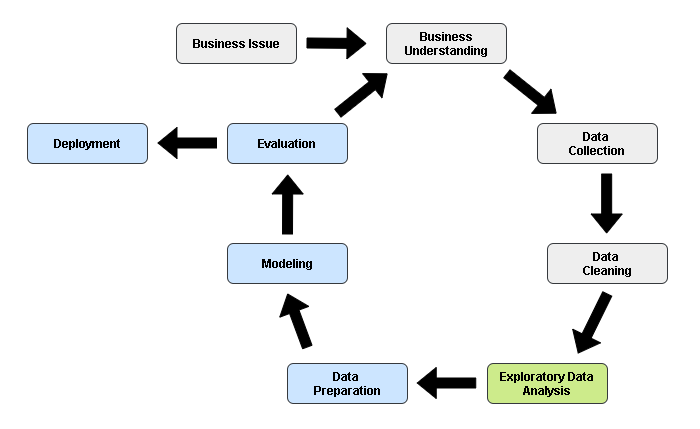

In [18]:
Image("img/crisp.png")

Metrics: <br>
* Central tendency: average, median
* Dispersion: variance, standard deviation, amplitude

Although descriptive statistics is compatible with numerical and categorical data, the form of construction is different. Therefore, I need to separate into numerical data and categorical data.

In [19]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical attributes

In [20]:
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


The following are some examples of variable distribution to begin to understand the distribution of the number of records for each of them:

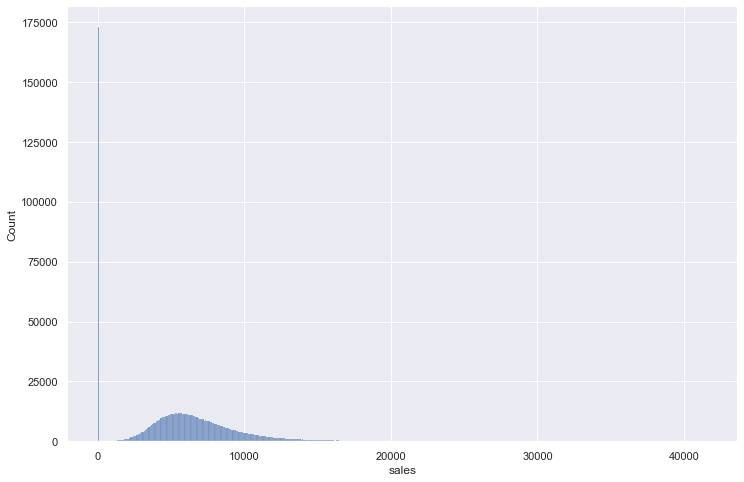

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(df1["sales"]);

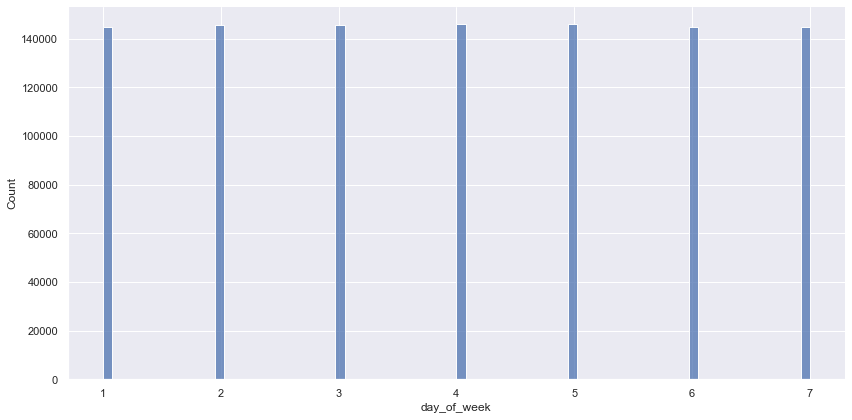

In [22]:
sns.displot(df1["day_of_week"], height=6, aspect=2);

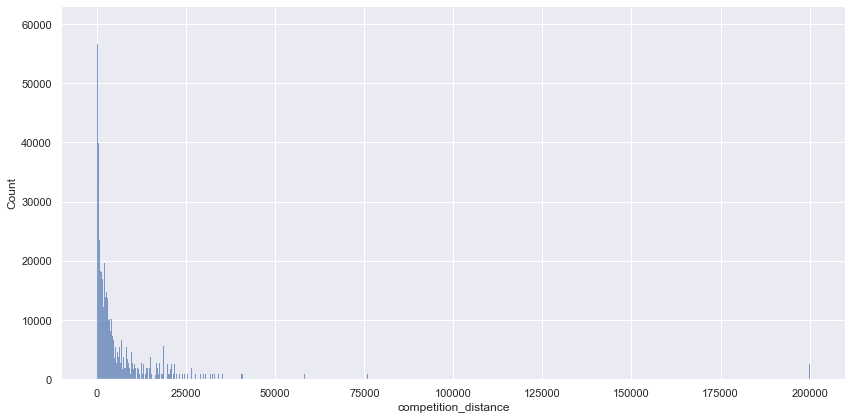

In [23]:
sns.displot(df1["competition_distance"], height=6, aspect=2);

### 1.7.2 Categorical attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# another way to get the same result
#cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

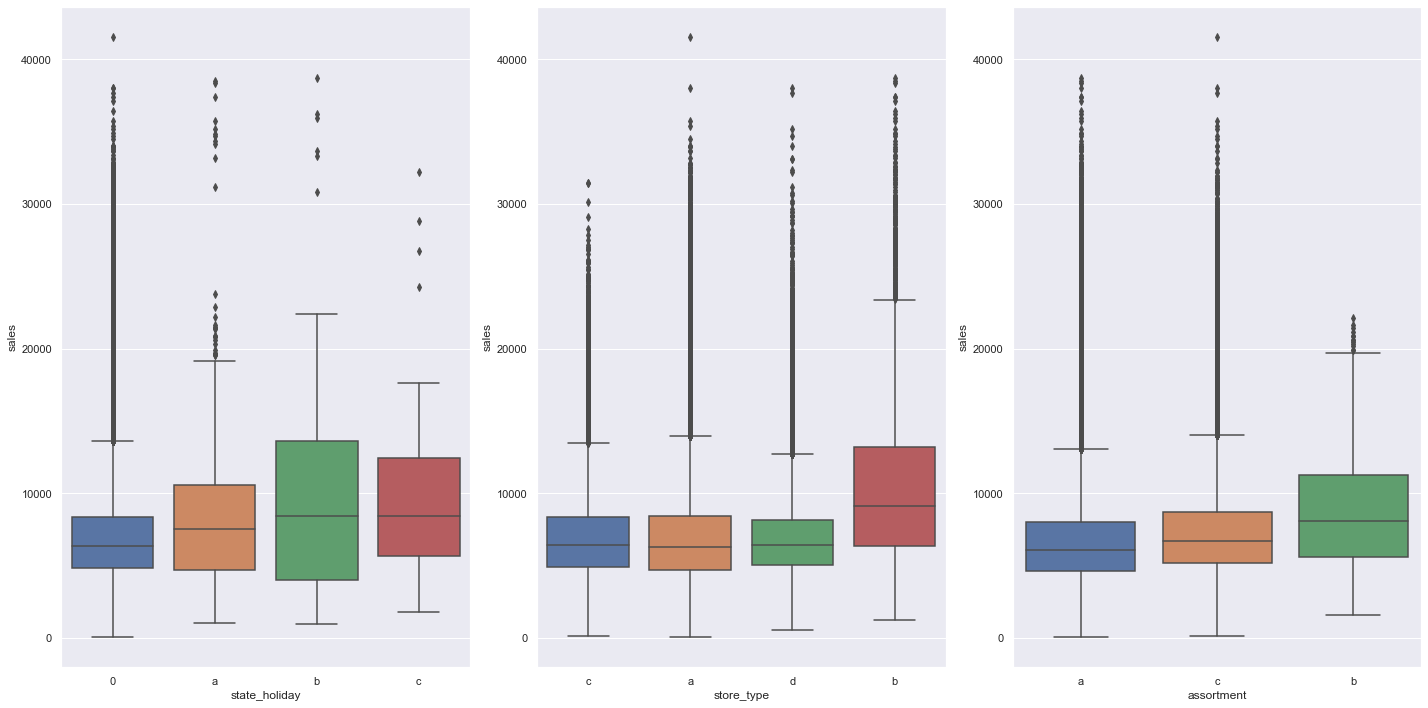

In [25]:
# discard data when stores were closed or when the sale was null
aux1 = df1[(df1["open"] == 1) & (df1["sales"] > 0)]
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)

plt.tight_layout()

In the boxplot charts above, the outliers are those considered to be above 1.5 of the interquartile range (IQR) The image below illustrates this.

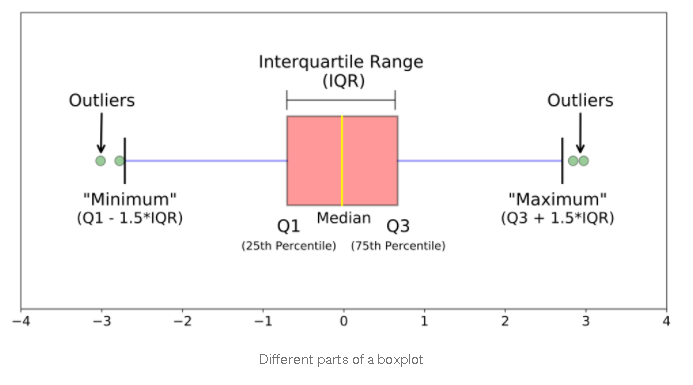

In [26]:
# source: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
Image("img/box_plot.png")

# 2.0. FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

Hypothesis mind map:
* Phenomenon: What am I modeling (Daily Store Sales)
* Agents: What are the agents that act on the phenomenon (five main branches)
* Agent Attributes: What is the description of the agents (branches on each of the agents) <br>

The goal is to derive a list of hypotheses so that we can validate them or not with the data.
Every hypothesis validated or discarded is the insight.

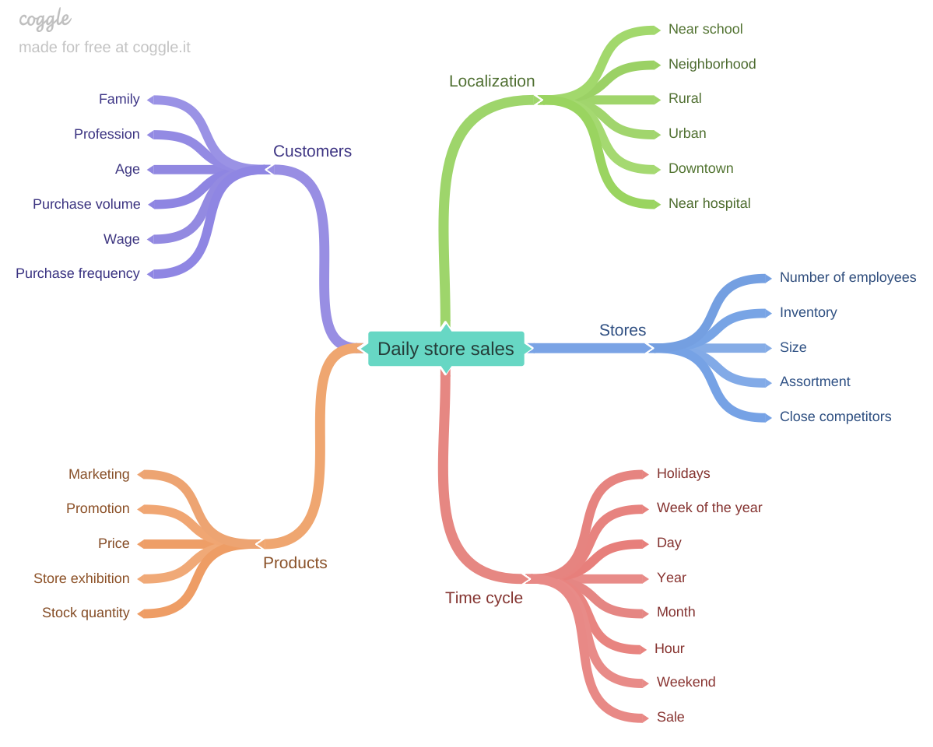

In [28]:
Image("img/MindMapHypothesis.png")

The hypotheses mind map above will be used to extract hypotheses to validate them further during exploratory data analysis. To write hypotheses, consider them as a bet, as shown in the examples below: <br>
"BIGGER stores should sell MORE." (Note that I am citing an attribute of an agent (store size) and betting on the correlation on the response variable (sales). <br>
"BIGGER assortment stores should sell MORE." <br>
"Stores with MORE competitors around should sell LESS."


## 2.2 Hypotheses

### 2.2.1. Store hypotheses

**1.** Stores with more employees should sell more <br>
**2.** Stores with more inventory should sell more <br>
**3.** Bigger stores should sell more (or smaller stores should sell less) <br>
**4.** Stores with a larger assortment should sell more <br>
**5.** Stores with closer competitors should sell less <br>
**6.** Stores with longer-standing competitors should sell more

### 2.2.2. Product hypotheses

**1.** Stores that invest more in marketing should sell more <br>
**2.** Stores that display more in store windows should sell more <br>
**3.** Stores where products cost less should sell more <br>
**4.** Stores with more aggressive promotions (larger discounts) should sell more <br>
**5.** Stores where products cost less for longer (active promotions) should sell more <br>
**6.** Stores with more promotion days should sell more <br>
**7.** Stores with more extended promotions should sell more <br>

### 2.2.3. Time hypotheses

**1.** Stores open during Christmas holiday should sell more <br>
**2.** Stores should sell more over the years <br>
**3.** Stores should sell more in the second half of the year <br>
**4.** Stores should sell more after the 10th day of each month <br>
**5.** Stores should sell less on weekends <br>
**6.** Stores should sell less during school holidays <br>
**7.** Stores that open on Sundays should sell more <br>


## 2.3 Hypotheses prioritization

As we are working on the CRISP method, we are going to validate the hypotheses that we are already able to verify with the current set of data obtained. If for the hypothesis it is necessary to make one more query in SQL, extract, store and process the data, then it is better to do it in the next CRISP cycle, if necessary.
The hypotheses below were taken from sections 2.2.1 to 2.2.3 because, in the available dataset, they are the only ones that can be verified.

**1.** Stores with a larger assortment should sell more <br>
**2.** Stores with closer competitors should sell less <br>
**3.** Stores with longer-standing competitors should sell more <br>

**4.** Stores where products cost less for longer (active promotions) should sell more <br>
**5.** Stores with more promotion days should sell more <br>
**6.** Stores with more extended promotions should sell more <br> 

**7** Stores open during Christmas holiday should sell more <br>
**8.** Stores should sell more over the years <br>
**9.** Stores should sell more in the second half of the year <br>
**10.** Stores should sell more after the 10th day of each month <br>
**11.** Stores should sell less on weekends <br>
**12.** Stores should sell less during school holidays <br>
**13.** Stores that open on Sundays should sell more <br>

## 2.4 Feature engineering

In [29]:
# creation of new columns to use in the EDA and validation/refutation of selected hypotheses

# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week #capture the week of the year

# year week
df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

# competition_time_month (before it is necessary to join year and month)
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

# promo since (we want to know how long the store joined the promo2)
# as week %W starts with 0, subtract 7 days
df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

# promo_time_week
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# state holiday
df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})


In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [31]:
df2.state_holiday.value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

# 3.0 FILTERING OF VARIABLES

The motivation for business filtering is business restrictions. The impossibility of putting the model into production should be avoided due to the need to use some feature that is not available for future data (whose past value is available in the dataset). The risk of such impossibility is mitigated by taking into account business restrictions. That is why it is important to be within the beginning of the CRISP cycle. <br>
An example of business restriction: in the development of a project to forecast the sales of a product, it was found that the variable "applied discount" had a strong correlation with the sales volume. The model was then trained using this variable. But the business team said it was impossible to know the discount before the product was launched. Therefore, at the time of prediction, in production, it is not possible to use it. That's why it's important to filter the variables before starting the project itself.

In [32]:
df3 = df2.copy()

## 3.1 Rows selection

The "open" column indicates whether the store is open (1) or closed (0); however when it is closed, sales are 0; so I don't have any learning extracted from the lines where "open" equals 0.
The same for the "sales" column.

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns selection

The "customers" column we don't have at the time of prediction; we don't know how many customers will have 6 weeks from now (this would require another project). <br>
In addition to this, the "open" column (which after 3.1 only have the value '1'), the "promo_interval" and "month_map" columns (that were used to derive the "is_promo" column) will also be excluded.

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# 4.0 EXPLORATORY DATA ANALYSIS

How do variables impact the phenomenon & what is the strength of that impact?

The 3 goals of EDA:
- Gain business experience
- Validate business hypotheses (insights)
    - Generate surprise and counteract beliefs empirically crystallized by the business team
- Realize variables that are important to the model

The following analyzes will be carried out during EDA:
- Univariate analysis
    - What is this variable like (min, max, range, distribution) ?
- Bivariate analysis
    - How does the variable impact the target attribute (relationship, validation of hypotheses) ?
- Multivariate analysis
    - How the variables are related (correlation between them) ?

In [35]:
df4 = df3.copy()

Before starting the next sections, let's update the descriptive data analysis:

In [36]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


## 4.1 Univariate analysis

### 4.1.1 Target variable

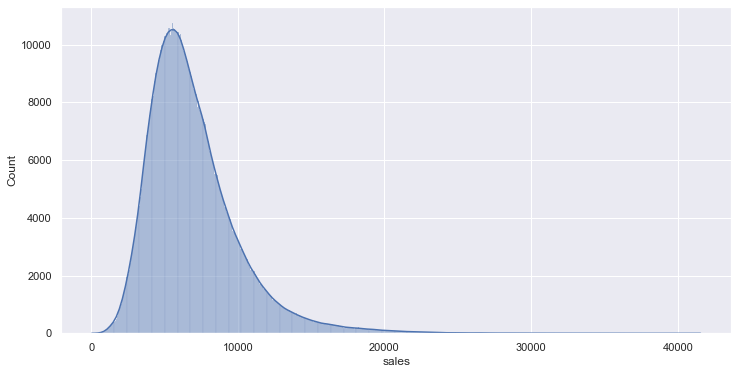

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df4['sales'], kde = True, ax = ax)
plt.show()

A curiosity: it was mentioned that applying log1p to the distribution (which is not normal) would make the distribution "more normal"; however, using scipy's normal test we didn't notice a difference. <br>
This topic will certainly be discussed a lot throughout my studies and I leave this observation registered here. <br> 
Another method that was mentioned to transform the distribution into normal is boxcox, which also did not change the p value in normaltest.

In [38]:
a = (df4['sales']) 
b = np.log1p(df4['sales'])  #transf. log1p
c, _ = stats.boxcox(df4['sales']) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    #shapiro_test = stats.shapiro(eval(teste))
    print(f'The p-value of {teste} is {p}')
    #print(f"shapiro test is {shapiro_test} \n")

The p-value of a is 0.0
The p-value of b is 0.0
The p-value of c is 0.0


An interesting point is that if the sample is smaller, there is an evident increase in the p_value, as expected, after the transformation. This dependence of the sample size with the p_value will also be the target of future investigations.

In [39]:
sample = df4['sales'].sample(1000, random_state=41896)
a = sample
b = np.log1p(sample)  #transf. log1p
c, _ = stats.boxcox(sample) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    #shapiro_test = stats.shapiro(eval(teste))
    print(f'The p-value of {teste} is {p}')
    #print(f"O teste shapiro é {shapiro_test} \n")

The p-value of a is 8.327224614050526e-64
The p-value of b is 0.003646314058067798
The p-value of c is 0.11362310846342781


### 4.1.2 Numerical variable

c:\users\rnfavar.embad.000\miniconda3\envs\dev_ds_producao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


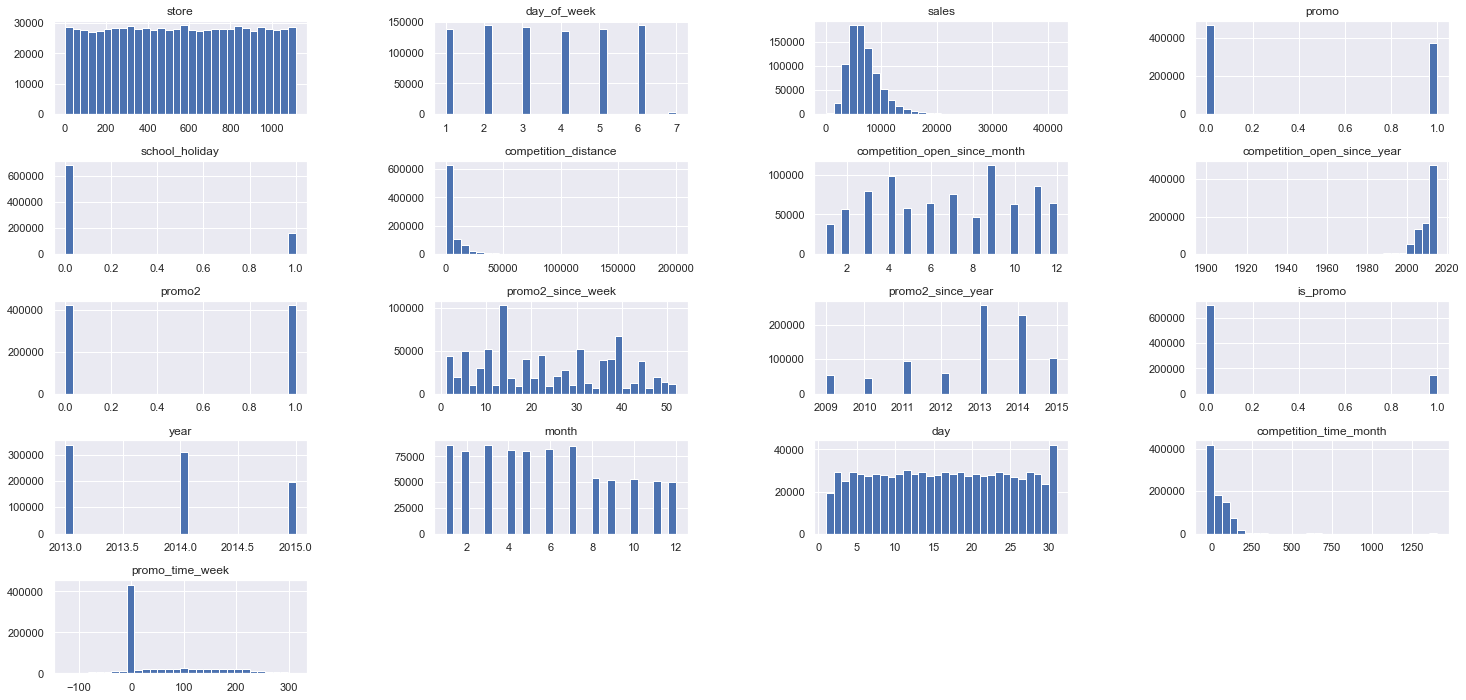

In [40]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,4));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Some preliminary analyses:

- the number of data from each store is approximately equal
- the availability of sales data on each of the 7 days of the week is also uniform
- the distribution of the sales value obtained by the different stores does not follow a normal distribution
- the same distribution of sales seems to occur for the number of customers
- most of the competitors appear to have opened in September, followed by April
- promo2 is present in half of the available data
- the year where the most beginning of promo2 occurred was 2013
- promo2 seems to start more in the first half of the year (first 26 weeks)
- there is no normal distribution

### 4.1.3 Categorical variable

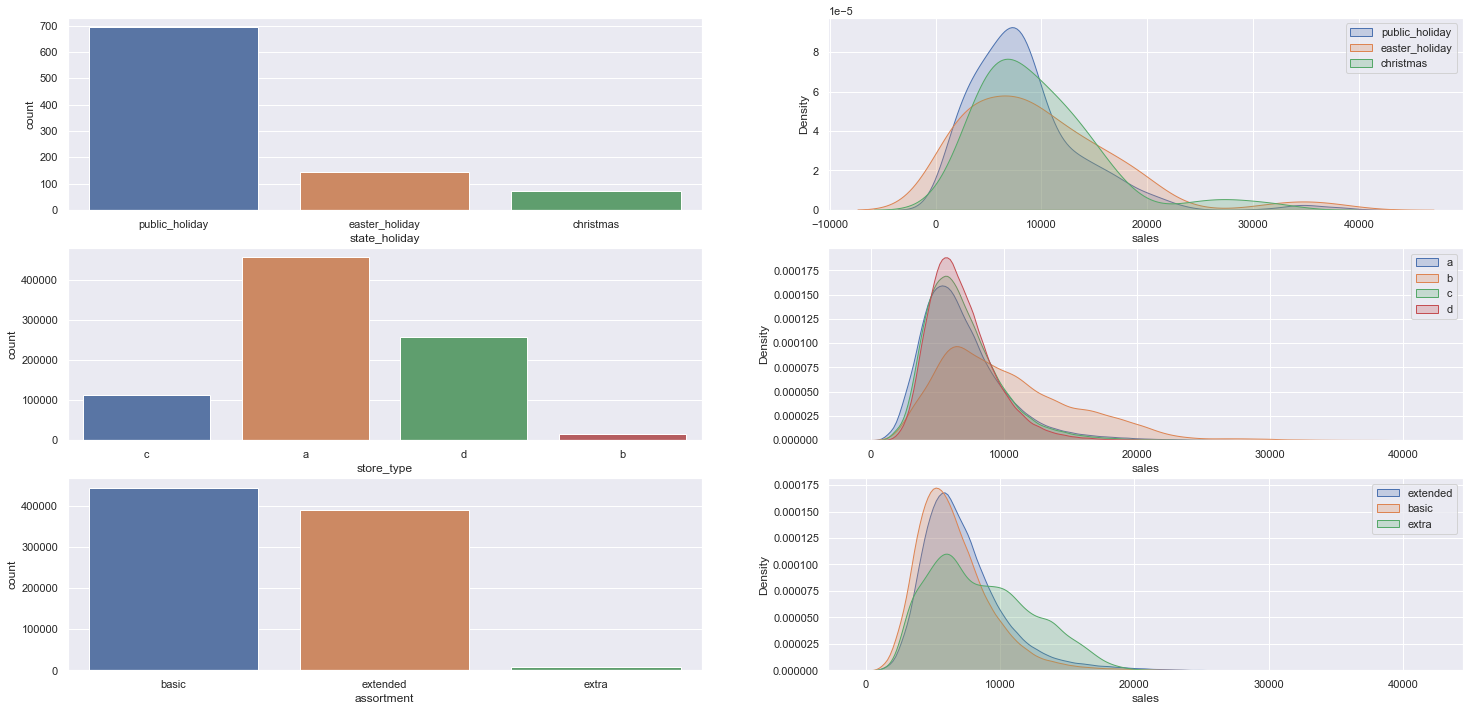

In [41]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()

In the figure above, on the left, there is the amount of data present for the categorical variables: 'state_holiday' (excluding the 'regular_day' which is the most part of the data), 'store_type' and 'assortment'. <br> 
On the right, there is the distribution of the sales value of these same categorical variables in relation to the sales value, starting, therefore, the bivariate analysis that will be much more worked on in the next section, with the validation or refutation of the different hypotheses raised.

## 4.2 Bivariate analysis

All hypotheses prioritized in section 2.3 will be validated or refuted in this section.

### H1. Stores with a larger assortment should sell more

**true:** stores with a larger assortment tend to sell more

First, the quantity of each store representing each assortment is observed.

In [42]:
df4[['store','assortment']].drop_duplicates().groupby('assortment').count()

,store
assortment,
basic,593
extended,513
extra,9


As there is considerable variation, especially in relation to the "extra", we will carry out an analysis of the average performance for each of these types of assortment present in the stores.

In [43]:
df4[['assortment', 'sales']].groupby('assortment').describe()

sales                                                                    
               count         mean          std     min     25%     50%      75%      max
assortment                                                                              
basic       444875.0  6621.523057  2972.050174    46.0  4611.0  6082.0   8000.0  38722.0
extended    391254.0  7300.843547  3183.849717   133.0  5156.0  6675.0   8703.0  41551.0
extra         8209.0  8642.503594  3803.116031  1580.0  5606.0  8088.0  11271.0  22137.0

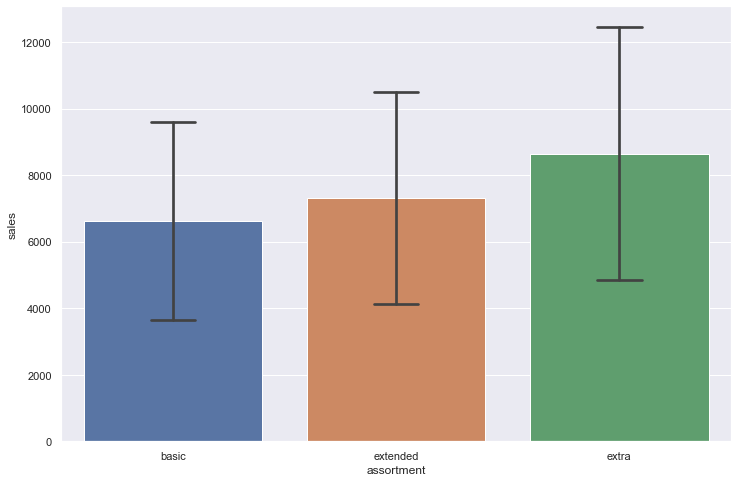

In [44]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'assortment', y='sales', data = df4, estimator = np.mean, ci = 'sd',capsize=.2);

To investigate the seasonal effect of such sales in relation to different types of assortment we can create a time series.

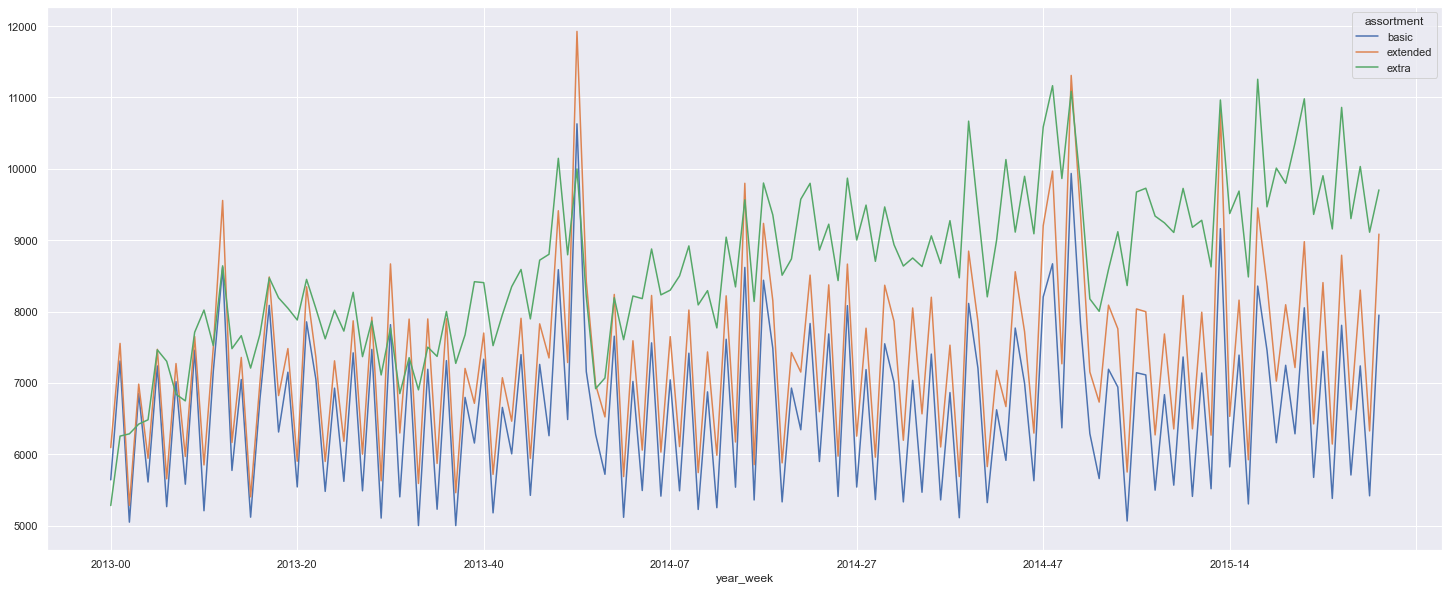

In [45]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(25,10));

Apparently, there is an increase of the sales as time passes for stores with "extra" assortment in relation to those with "basic" and "extended" assortment.
When observing the monthly moving average (4 weeks) this effect becomes clearer.

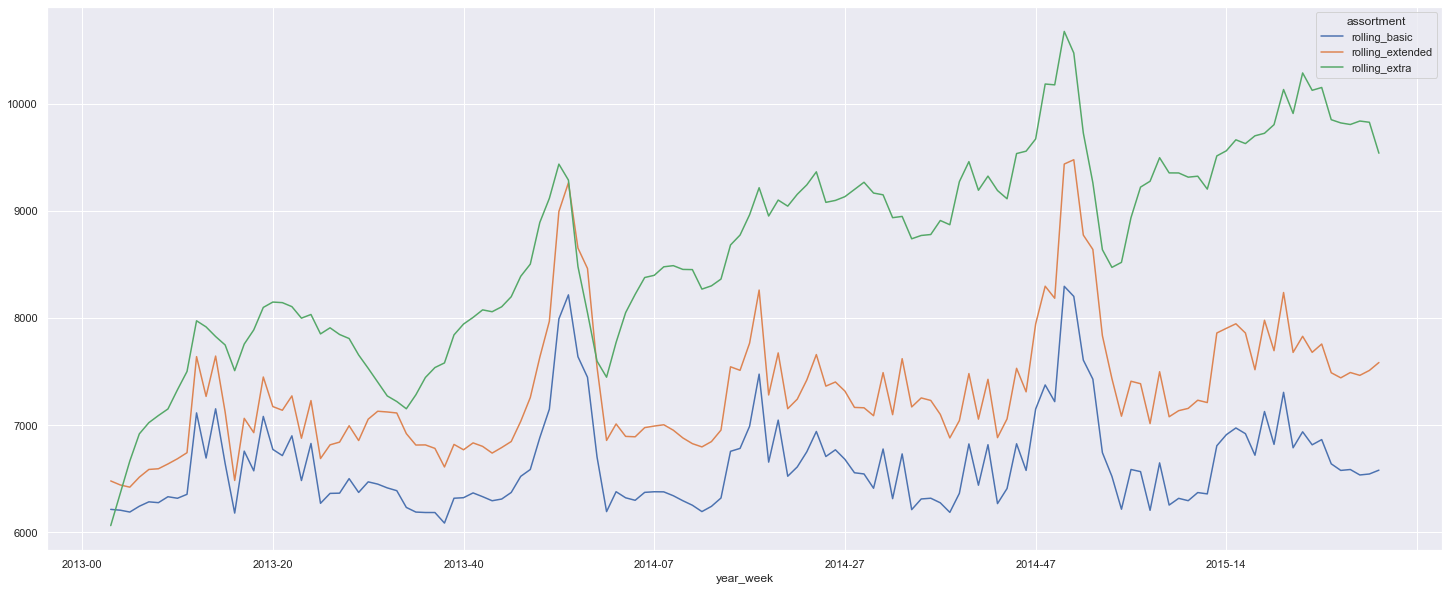

In [46]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));


The verdict of hypothesis H1 is that **"yes, stores with a larger assortment tend to sell more"**

It is important to be careful when choosing the statistical function behind each of these graphs. Some people use the function "sum" instead of "mean", which completely reverse the analysis:

- sales from stores with the "basic" assortment seemed to be higher compared to the "extended" assortment;
- sales from stores with "extra" assortment appeared to be negligible

See the graphics below:

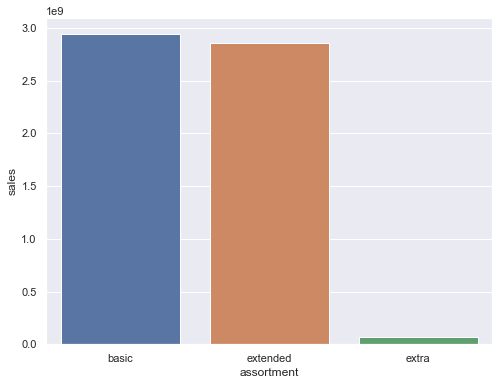

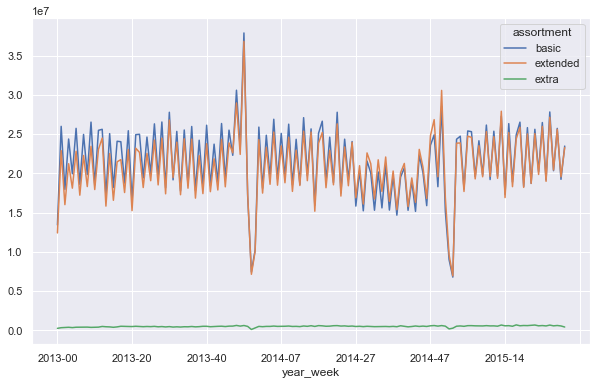

In [47]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'assortment', y='sales', data=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index());

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(10,6));

### H2. Stores with closer competitors should sell less
**false:** no, stores with closer competitors do not sell less (or more) than stores with more distant competitors


When plotting the average sales value in different small distance interval groupings, the following distribution is obtained:

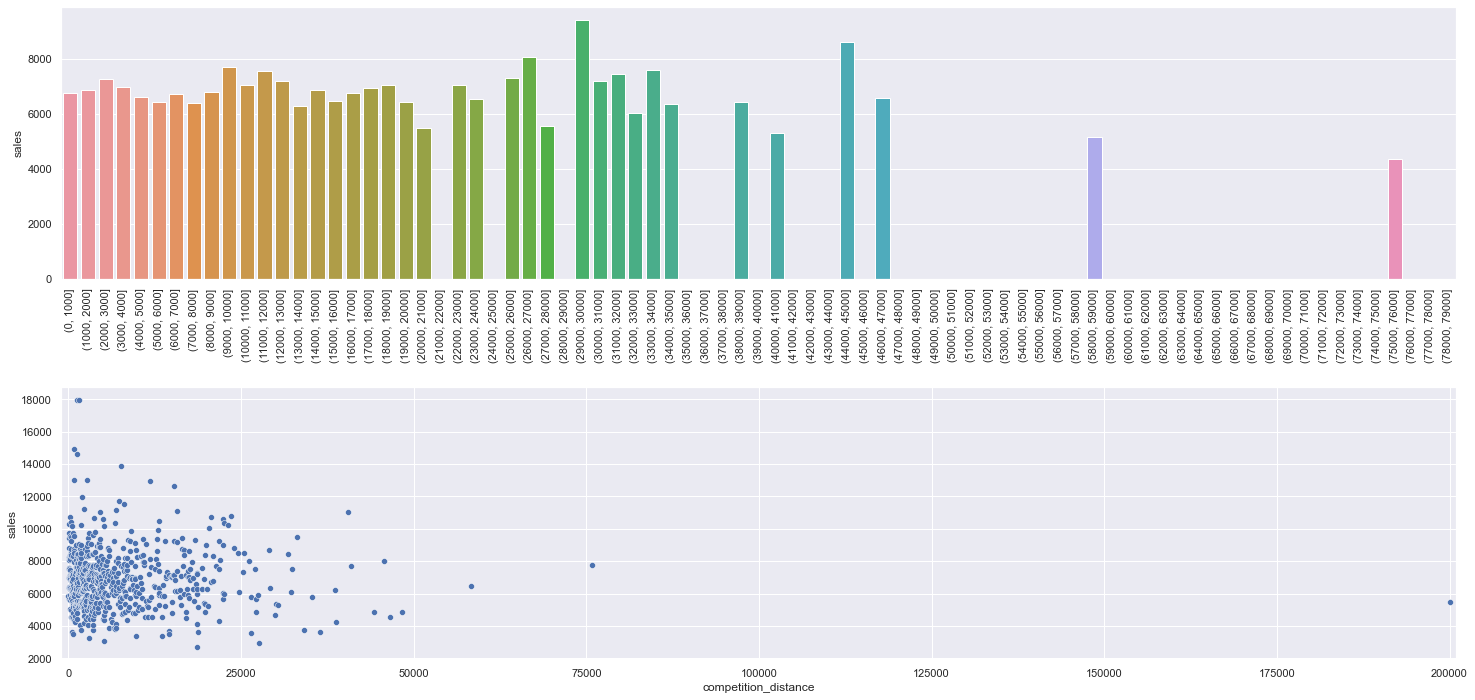

In [48]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,80000, 1000))
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
plt.figure(figsize=(25,12))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xlabel("")
plt.xticks(rotation=90)

plt.subplot(2,1,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)
plt.xlim(-1000,201000);


From the charts above, there is no apparent correlation between the average sales value and the distance to the nearest competitor. This observation is confirmed by plotting the Pearson correlation graph below:

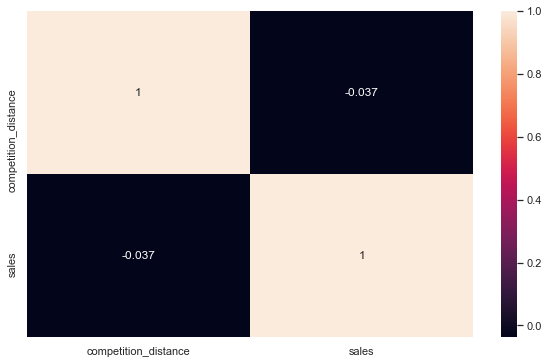

In [49]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'),annot=True);

The verdict of hypothesis H2 is that **"no, stores with closer competitors do not sell less (or more) than stores with more distant competitors"**.

The same comment at the end of H1 is made here: if instead of considering the average, the sum of sales is considered, the analyzes would be completely different:

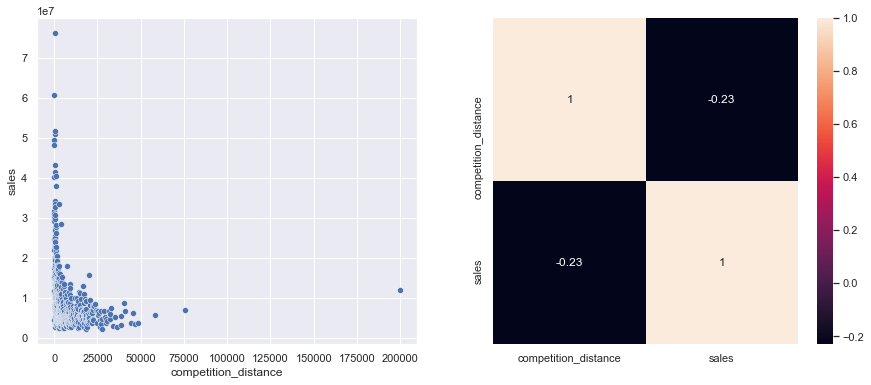

In [50]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1,2,2);
sns.heatmap(aux1.corr(),annot=True)
plt.show()
                

### H3. Stores with longer-standing competitors should sell more
**false:** no, stores with longer-standing competitors do not sell more than stores with more recently opened competitors

When plotting the time that the closest competitor is open, the following distribution is obtained:

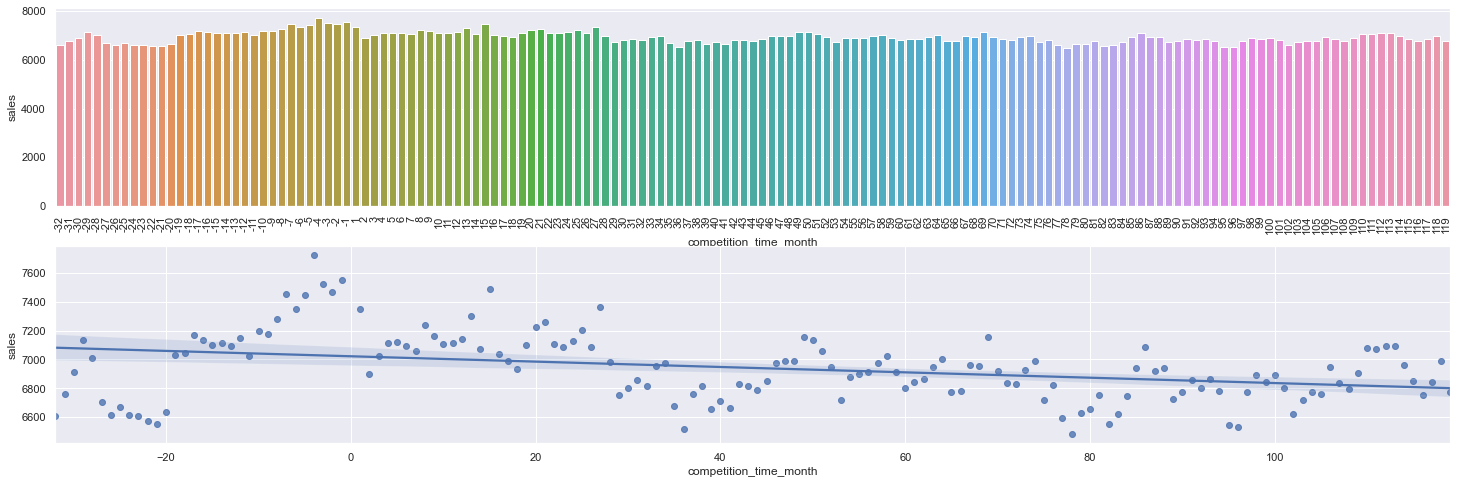

In [51]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

Negative x-axis values are due to sales records before the current nearest competitor opens. <br>
We noticed that there are records of higher sales trend in the twelve months before competitors open. <br>
Also, once the competitor opens, sales begin a downward trend, with no significant recovery being observed for at least the first 120 months (10 years) of the open competitor. <br>
Such a trend is also suggested in the Pearson correlation below:

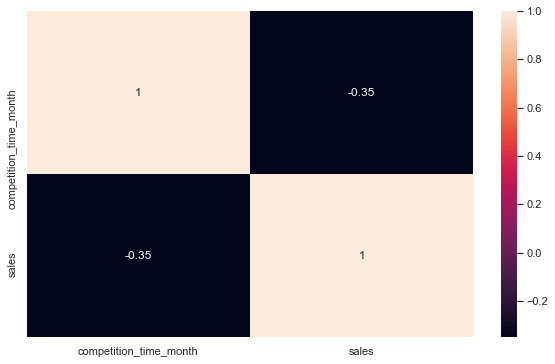

In [52]:
plt.figure(figsize=(10,6))
sns.heatmap(aux2.corr(method='pearson'),annot=True);

The verdict of hypothesis H3 is that **"no, stores with longer-term competitors do not sell more than stores with more recently opened competitors"**.

### H4. Stores where products cost less for longer (active promotions) should sell more
**true:** yes, stores where products cost (or have cost) less for longer tend to sell more

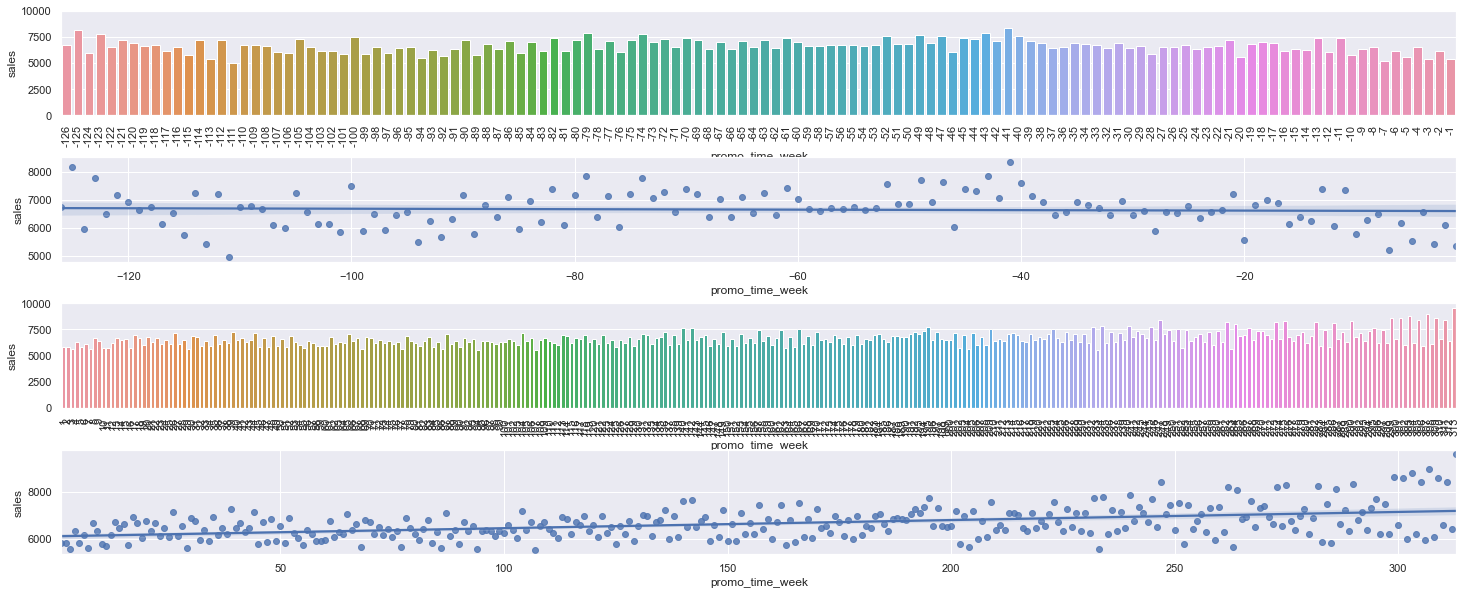

In [53]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

plt.figure(figsize=(25,10))
plt.subplot(4,1,1)
aux2 = aux1[aux1['promo_time_week'] < 0] # sales in stores that have never had any extended promotions
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,3)
aux3 = aux1[aux1['promo_time_week'] > 0] # sales in stores that have already had an extended promotion
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);



On average, sales that occurred in stores that never adopted the promo2 were constant; on the other hand, sales that occurred in stores that have already adopted the promo2 show a tendency, albeit timid, to increase over time. The Pearson correlation shown below complements the analysis:

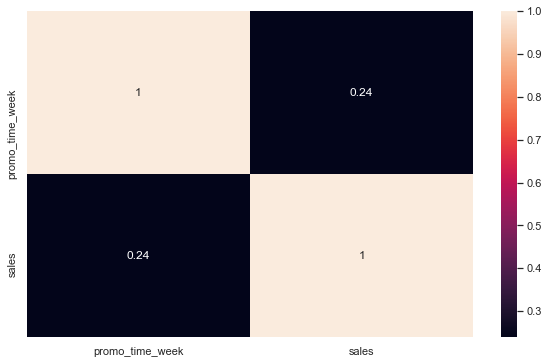

In [54]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Hypothesis H4's verdict is that **"yes, stores where products cost (or have cost) less for longer tend to sell more"**

### <s> H5. Stores with more promotion days should sell more </s>


As it is very similar to H4, it will be evaluated in the next CRISP cycle if necessary.

### H6. Stores with more extended promotions should sell more
**false:** no stores that have a higher amount of extended promotions tend to sell less, on average, compared to stores that only feature the traditional promotion.

On average, it appears that stores that adhered to promo1 tend to sell more than promo2 (which is the extended promotion), according to table below.

In [55]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


Next, it will be analyzed whether we notice any change in behavior over time.

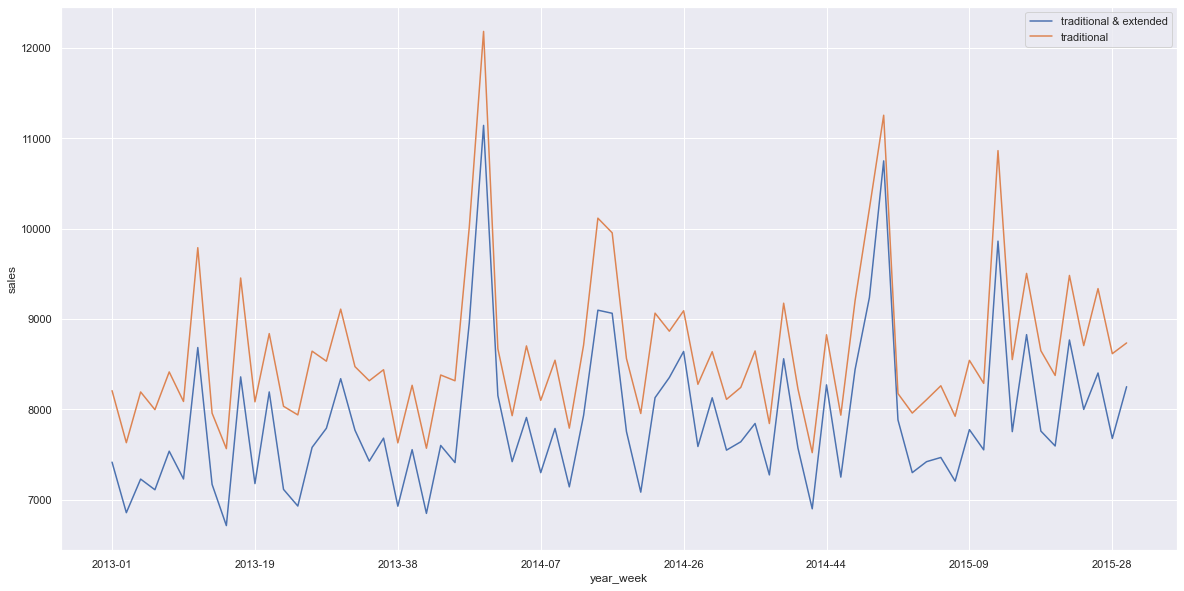

In [56]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux1.set_index('year_week',inplace=True)
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.set_index('year_week',inplace=True)
aux2.plot(ax=ax, figsize=(20,10),xlabel='year_week',ylabel='sales')

ax.legend(labels=['traditional & extended', 'traditional'])
plt.show()

Sales under the traditional promotion alone have always been equally higher than sales under the traditional and extended promotions at the same time during the period available in the dataset.

Hypothesis H6's verdict is that **"no, stores that feature more extended promotions tend to sell less, on average, compared to stores that feature only the traditional promotion"**.

### H7. Stores open during Christmas holiday should sell more
**true**: yes, sales during the Christmas holiday are possibly more expressive compared to sales on public holidays and common days, only losing or tying with the Easter holiday.

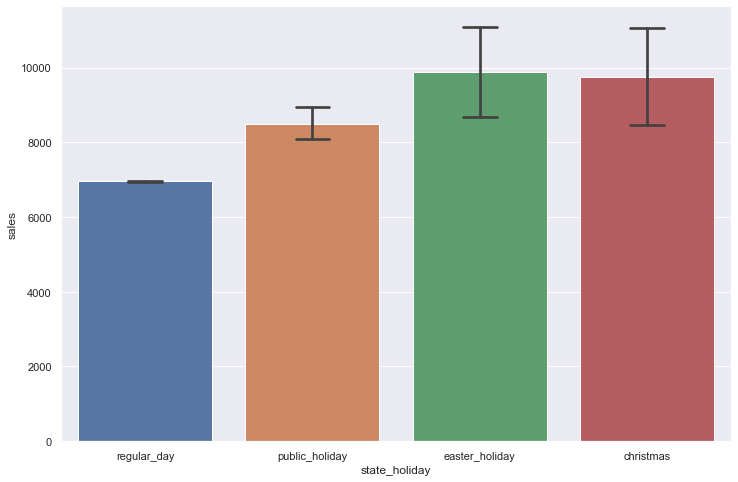

In [57]:
plt.figure(figsize=(12,8))
sns.barplot(x='state_holiday', y='sales', data=df4, estimator = np.mean, capsize=.2)
plt.show()

Note that the Christmas holiday, accompanied by Easter, are the two holidays where sales, on average, are higher.
Next, an analysis will be carried out over the years.

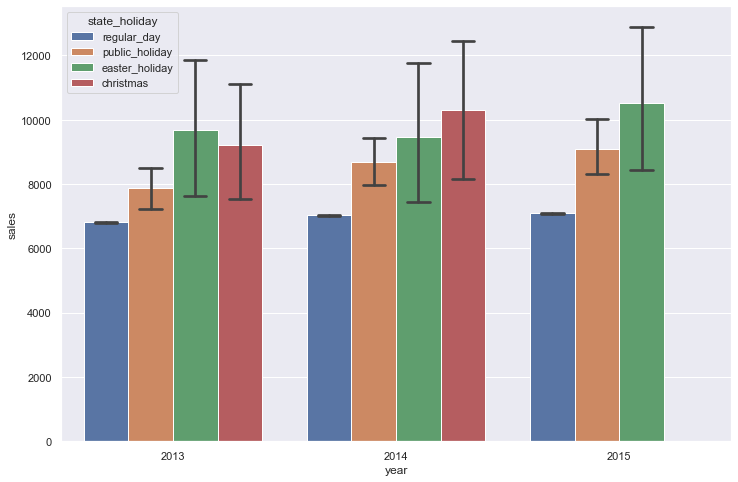

In [58]:
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='sales', hue='state_holiday', data=df4, estimator = np.mean, capsize=.1)
plt.show()

From the figure above, apparently the sales during Christmas 2014 was more expressive compared to Christmas 2013. And in 2015 it's as if the year was under construction, as the last day of the data is on 07/31/2015, so it ends before Christmas.

Hypothesis H7's verdict is that **"yes, sales during the Christmas holiday are possibly more expressive compared to sales on public holidays and common days, only losing or tying with the Easter holiday"**.

###  H8. Stores should sell more over the years


**inconclusive:** as there are only 2-year data (2013 and 2014), this hypothesis cannot be affirmed or refuted. However, it can be said that, on average, sales in 2014 were higher than in 2013".

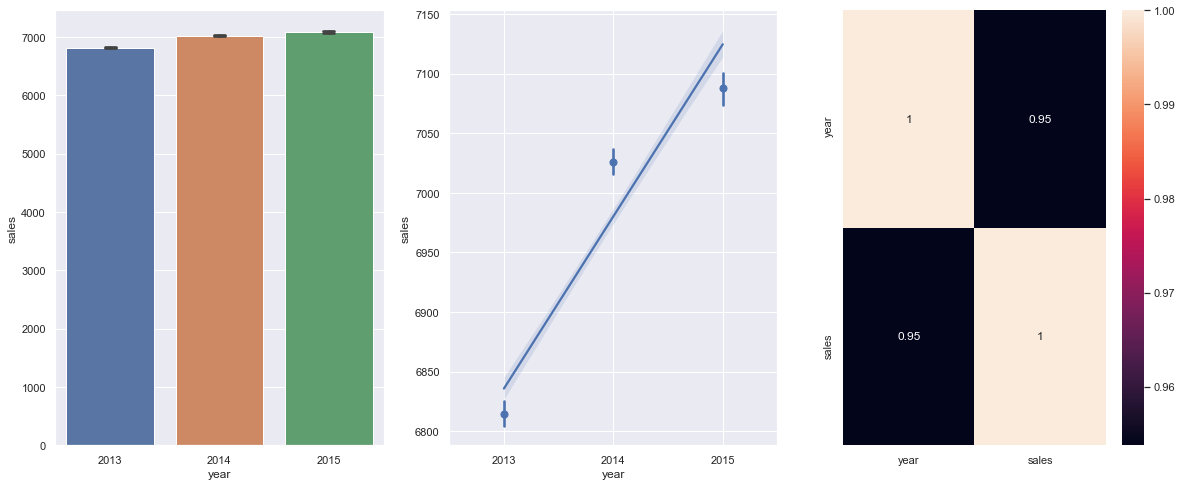

In [59]:
aux1 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(2012.5, 2015.5)
plt.xticks([2013,2014,2015])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

There are only 2 years with data from 01/01 to 31/12, which is 2013 and 2014. So this is not a comprehensive analysis; in 2015, average sales are not taking into account the second half. <br>
We can say that, on average, stores sold more in 2014 compared to 2013. <br> 
It is noteworthy that this analysis will hardly be an insight, since sales should be one of the metrics already monitored by the company.

Hypothesis H8's verdict is that it is **"inconclusive, as there are only 2-year data (2013 and 2014), this hypothesis cannot be affirmed or refuted. However, it can be said that, on average, sales in 2014 were higher than in 2013"**.

### H9. Stores should sell more in the second half of the year
**false:** it is not possible to say that there are more sales in the second semester; although the average is slightly higher, the fluctuation is higher


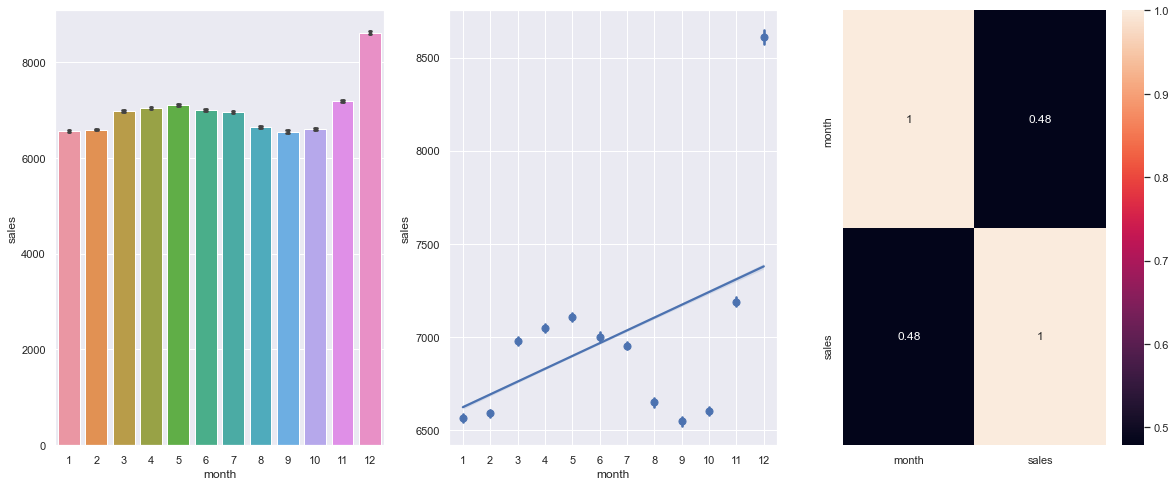

In [60]:
aux1 = df4[['month','sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 12.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Note that the second half of the year concentrate months with low sales (September and October) and months with high sales (November and December)
For now, it is inconclusive to say that in the second half it sells more or less compared to the first. For this, a new analysis can be performed:

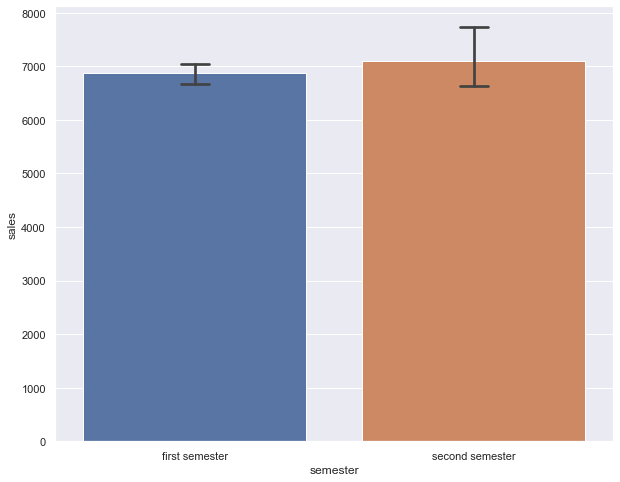

In [61]:
x = lambda x: 'first semester' if x in [1,2,3,4,5,6] else 'second semester'
aux1['semester'] = aux1['month'].apply(x)
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux1, estimator = np.mean, capsize=.1)
plt.show()

Hypothesis H9's verdict is that it is **"false, as it is not possible to say that there are more sales in the second half; although the average is slightly higher, the fluctuation is greater, as previously commented"**.

### H10. Stores should sell more after the 10th day of each month
**false:** before the 10th day of each month, stores sell slightly more

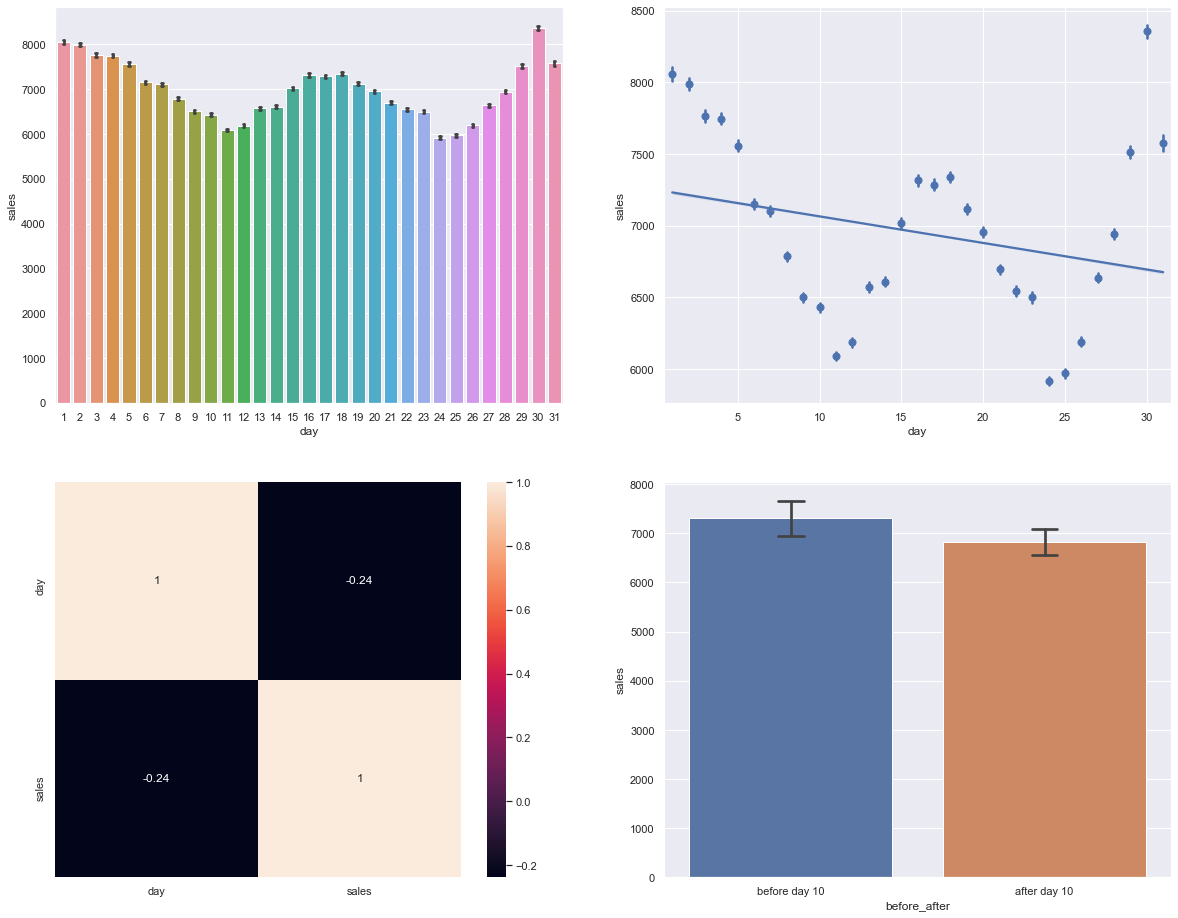

In [62]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 31.5)
plt.xlabel

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


x = lambda x: 'before day 10' if x <= 10 else 'after day 10'
aux1['before_after'] = aux1['day'].apply(x)
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1, estimator = np.mean, capsize=.1)


plt.show()

After analyzing the composition of the 4 graphs of this hypothesis, it is noted that before the 10th, on average, stores sell more. <br>
Highlight for sales in the first days of each month, although relatively high, in an almost constant fall until the 10th. It is also noticed that sales increase more towards the end of the month.

The verdict of hypothesis H10 is that it is **"false, because before the 10th, stores sell slightly more"**.

### H11. Stores should sell less on weekends
**true:** on weekends, in total, stores sell less

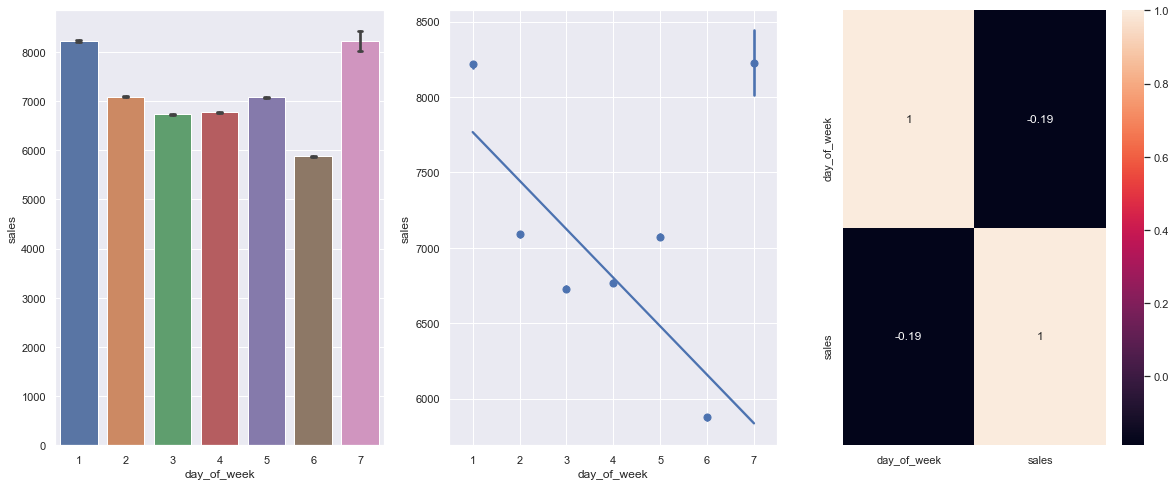

In [63]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 7.5)


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

It appears that the weekends, on average, have lower sales on Saturday and higher on Sunday. But if we add up the sales contributions from all stores, we see that weekends represent low sales overall.

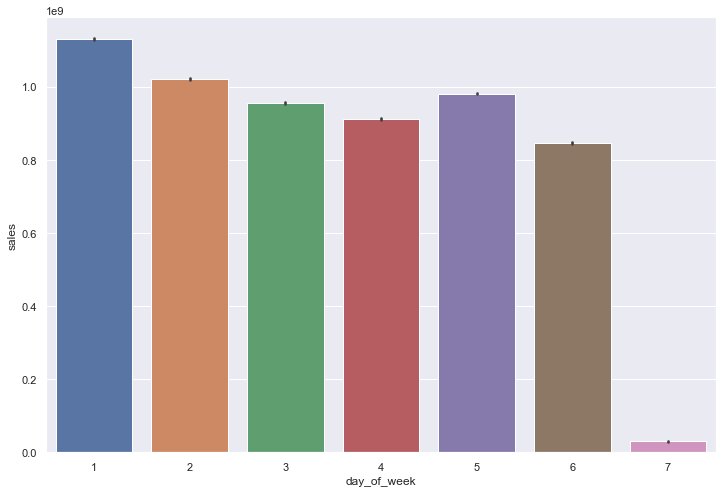

In [64]:
plt.figure(figsize=(12,8))
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.sum)
plt.show()

With this, it is also noted that, if on average, Sunday is the day of the week with the highest sales, but in total it is the day that sells the least, many stores should not open on Sundays. This matter will be dealt with in case 13.

The verdict of hypothesis H11 is that it is **"true, because on weekends, in total, stores sell less"**.

### H12. Stores should sell less during school holidays
**false:** on school holidays stores sell more, except in September and December.

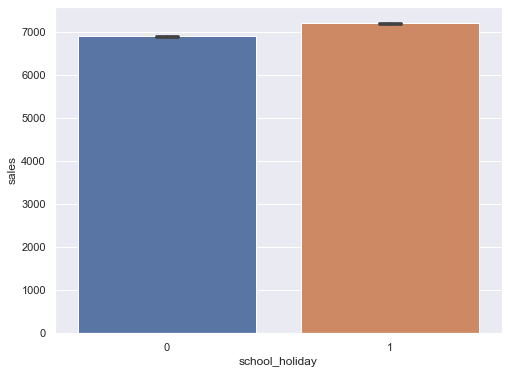

In [65]:
plt.figure(figsize=(8,6))
sns.barplot(x='school_holiday', y='sales', data=df4, estimator = np.mean, capsize=.1);

Com a análise do gráfico acima, percebe-se que nos feriados escolares, em média, vende-se mais; a seguir será feito uma análise por mês.

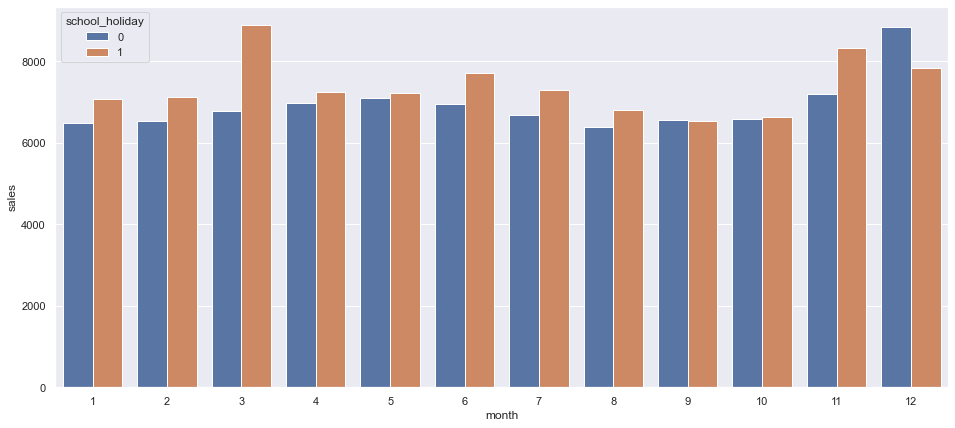

In [66]:
plt.figure(figsize=(16,7))
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x='month', y = 'sales', hue='school_holiday', data = aux1);

Note that, with the exception of September and December, on average more is sold on school holidays. Highlight for sales of the March and November school holidays.

Hypothesis H12's verdict is that it is **"false, because on school holidays, stores sell more"**.

### H13. Stores that open on Sundays should sell more
**true:** stores that open on Sunday sell more

This is an extra hypothesis that emerged after the conclusion of hypothesis 11. First, it is necessary to check the number of stores that open each day of the week.

In [67]:
df4[['day_of_week','store']].groupby('day_of_week').nunique()

,store
day_of_week,
1,1115
2,1115
3,1115
4,1115
5,1115
6,1115
7,33


After analyzing hypothesis 11, Sunday is the only day that fewer stores open, only 33.

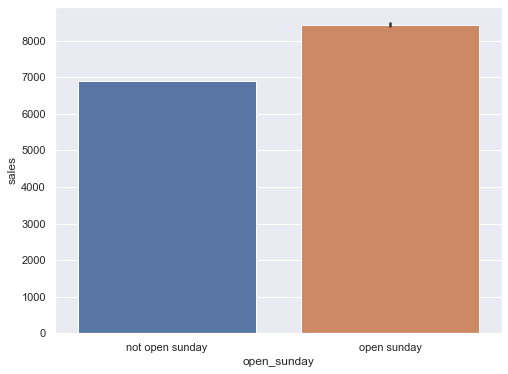

In [68]:
# captures stores that open on Sundays
stores_open_sunday = list(df4[df4['day_of_week']==7]['store'].unique())

x = lambda x: 'open sunday' if x in stores_open_sunday else 'not open sunday'
aux1 = df4[['store','sales','day_of_week']].copy()
aux1['open_sunday'] = aux1['store'].apply(x)

plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux1, estimator = np.mean)
plt.show()

After analyzing the above chart, it can be said that stores that open on Sundays sell, on average, more than stores that do not open on Sundays. But to be fairer in comparison, Sunday sales should be excluded, so stores that open on Sunday will have the performance of their sales from Monday to Saturday compared to sales of stores that do not open on Sunday.

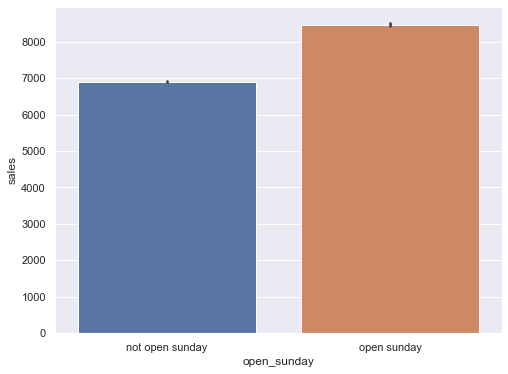

In [69]:
aux2 = aux1[aux1['day_of_week'] != 7]
plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux2, estimator = np.mean)
plt.show()

Even excluding Sunday sales, stores that usually open on that day of the week have a superior performance compared to stores that do not open on Sundays.

Hypothesis H13's verdict is that it is **"true, stores that open on Sunday sell more"**.

### 4.2.1 Summary of hypotheses

In [70]:
from tabulate import tabulate

tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1 - stores with a larger assortment should sell more', 'true','medium'],
       ['H2 - stores with closer competitors should sell lesss', 'false','low'],
       ['H3 - stores with longer-standing competitors should sell more','false','medium'],
       ['H4 - stores where products cost less for longer (active promotions) should sell more', 'true','low'],
       ['H5 - stores with more promotion days should sell more', 'not evaluated', '-'],
       ['H6 - stores with more extended promotions should sell more','false', 'high'],
       ['H7 - stores open during Christmas holiday should sell more', 'true', 'high'],
       ['H8 - stores should sell more over the years','inconclusive','high*'],
       ['H9 - stores should sell more in the second half of the year', 'false', 'medium'],
       ['H10 - stores should sell more after the 10th day of each month', 'false', 'high'],
       ['H11 - stores should sell less on weekends','true','high'],
       ['H12 - stores should sell less during school holidays', 'false', 'high'],
       ['H13 - stores that open on Sundays should sell more', 'true','high'],       
      ]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))
print("*although the H8 was inconclusive, I consider the variable 'year' to be highly relevant for the Machine Learning model")

╒══════════════════════════════════════════════════════════════════════════════════════╤═══════════════╤═════════════╕
│ Hypotheses                                                                           │ Conclusion    │ Relevance   │
╞══════════════════════════════════════════════════════════════════════════════════════╪═══════════════╪═════════════╡
│ H1 - stores with a larger assortment should sell more                                │ true          │ medium      │
├──────────────────────────────────────────────────────────────────────────────────────┼───────────────┼─────────────┤
│ H2 - stores with closer competitors should sell lesss                                │ false         │ low         │
├──────────────────────────────────────────────────────────────────────────────────────┼───────────────┼─────────────┤
│ H3 - stores with longer-standing competitors should sell more                        │ false         │ medium      │
├───────────────────────────────────────────────

## 4.3 Multivariate analysis

### 4.3.1. Numerical attributes

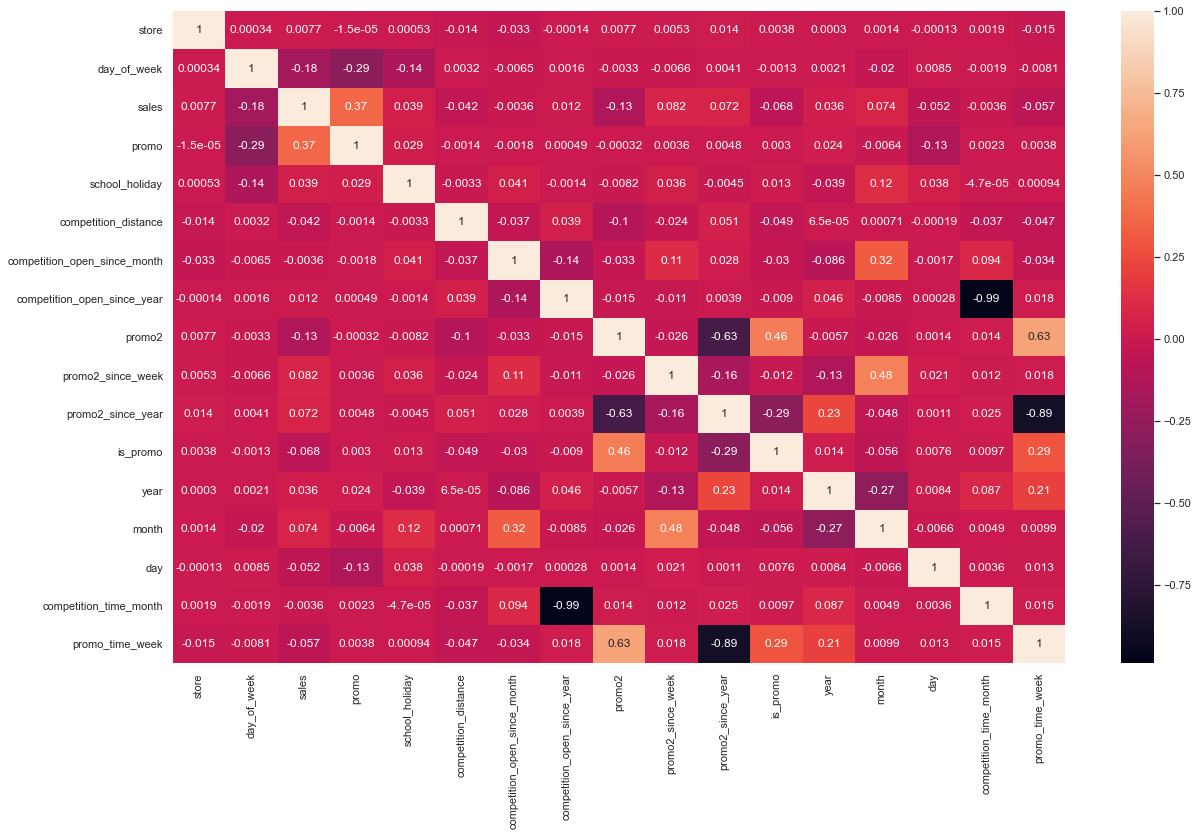

In [71]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes

In this section, the correlation analysis of categorical variables is performed following the method of Cramér's V (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) <br>
The function was defined in section 0.1.

In [72]:
# selects only columns of type 'object'
a = df4.select_dtypes(include='object')

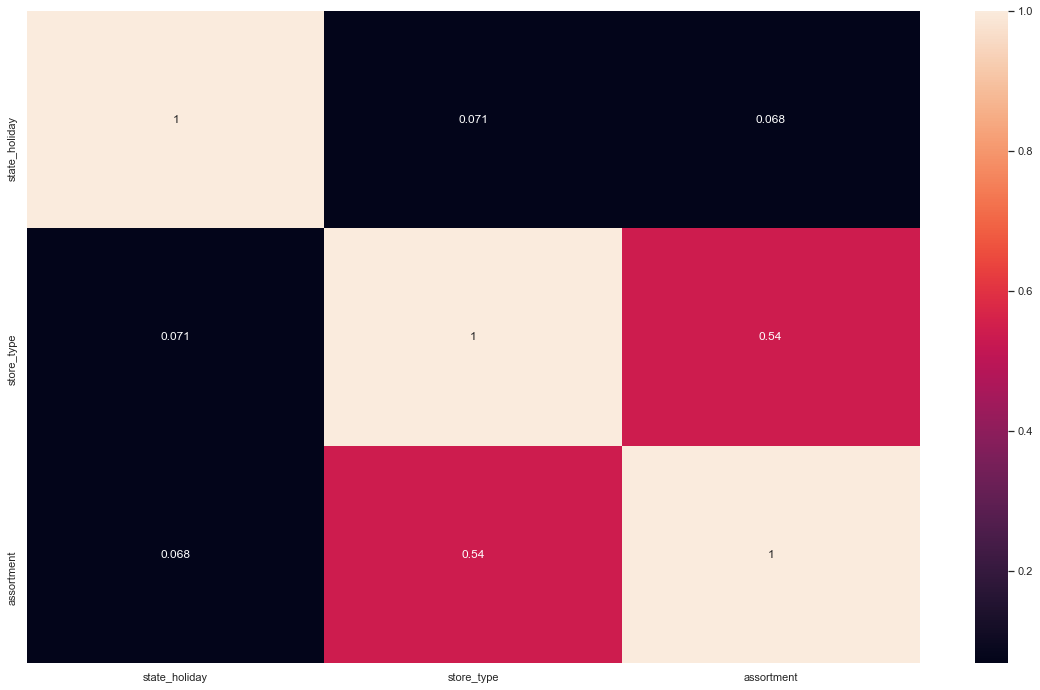

In [73]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#  final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]          
             })

d = d.set_index(d.columns)
plt.figure(figsize=(20,12))
sns.heatmap(d,annot=True);

Note that the variables 'store_type' and 'assortment' have a reasonable correlation.

# 5. DATA PREPARATION

In this section, data modeling begins, which involves preparing the data and filtering the most relevant variables for the model learning.

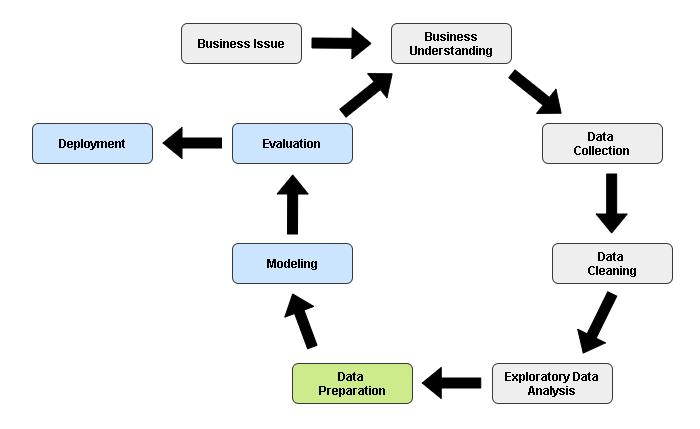

In [74]:
Image("img/crisp2.png")

Most machine learning algorithms is facilitated with numerical data, on the same scale. The next subsections are dedicated to transforming all variables into the same order of magnitude.

In [75]:
df5 = df4.copy()

## 5.1. Normalization

After consulting section 4.1.2 it is noted that there is no normal distribution. Therefore, normalization (which would be centered on 0 and adjust the standard deviation to 1) will not be applied to any data series.

## 5.2. Rescaling

In [76]:
# originally the 'week_of_year' series is as type UInt32; the conversion takes place.
df5['week_of_year'] = df5['week_of_year'].astype(np.int64)

In [77]:
df5.select_dtypes(include=['int32','int64','float64']).columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'competition_time_month', 'promo_time_week'],
      dtype='object')

The 4 variables (non-cyclic) where the rescaling will be performed are:
- 'competition_distance'
- 'year'
- 'competition_time_month'
- 'promo_time_week'

The choice between MinMaxScaler or RobustScaler is whether or not they have outliers

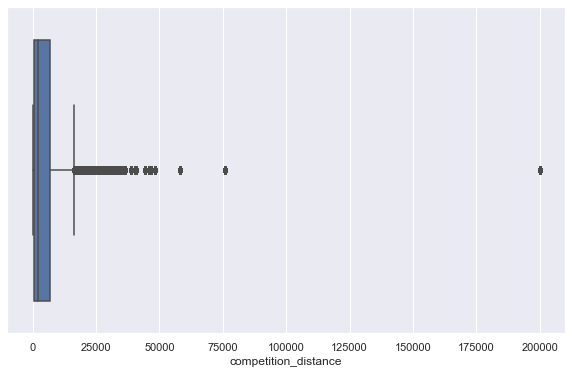

In [78]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

In section 1.5, outliers were inserted for the value of 200k, replacing the missing values; it was a way of signaling that the closest competitors, for stores where this value was nan, are actually very far away.
This variable will be rescaligned using RobustScaler.

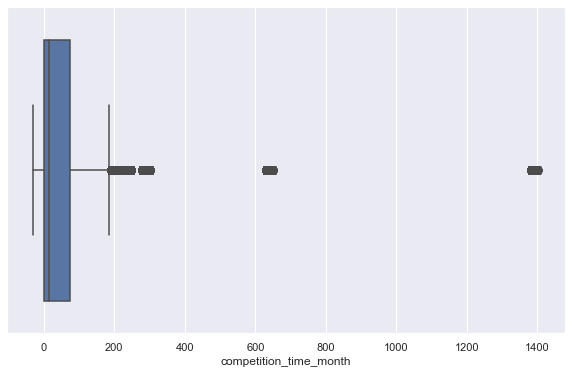

In [79]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

There are also many outliers on 'competition_time_month'. RobustScaler will be used.

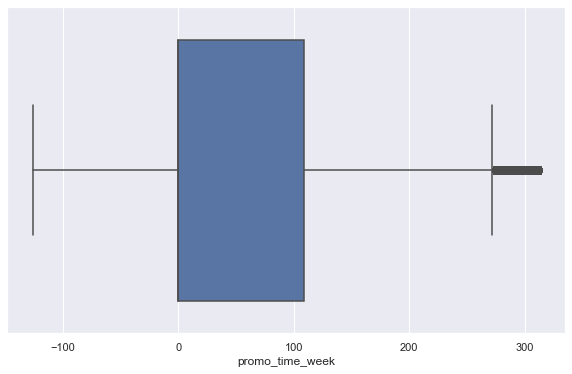

In [80]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

For this variable, outliers are not as relevant; MinMaxScaler will be used.

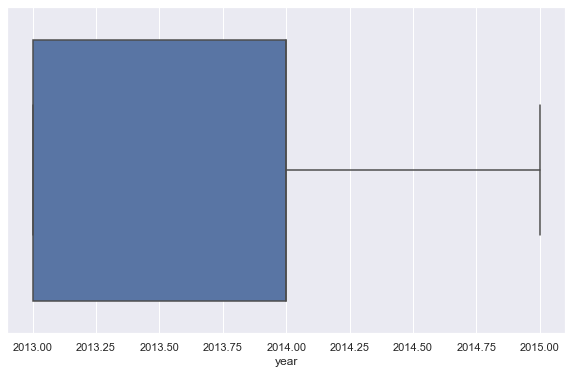

In [81]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

There are no outliers for the year; MinMaxScaler will be used.

In [82]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# save the scaler used for production use
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# save the scaler used for production use
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# save the scaler used for production use
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))

df5['year'] = mms.fit_transform(df5[['year']].values)
# save the scaler used for production use
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))




## 5.3. Transformation

### 5.3.1 Non-cyclical features encoding

The 3 variables (non-cyclic) where the encoding will be done are:
- 'state_holiday'
- 'store_type'
- 'assortment'

In [83]:
# one hot encoding: works great for 'states', such as 'sales taking place on a holiday or not'
df5 = pd.get_dummies(data=df5,prefix='state_holiday',columns=['state_holiday'])

# label_encoding: we don't know if the information present in the store_type has any relationship or if it's just labels
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# save the encoder used to use in production
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))


# ordinal encoding: assortment types have order: basic < extra < extendend
assortment_dict = {'basic':1, 'extra':2, 'extended':3} 
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Cyclical features encoding

To represent the cyclical nature of variables such as "months of the year" or "weeks of the year" we can break the variable into two others, sine and cosine.
More information: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [84]:
#month
df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2 * np.pi / 12)))


#day
# I did the division month by month (depending on the last day of the month), while some people use just 30.
# I thought it was risky because in the months that have 31 days, there will be the division "31/30", which will give more than 2pi, which will have a value very close (or even higher) than day 1

# create a dictionary with the months and the respective number of days
max_days_month = df5.groupby('month')['day'].max().to_dict()

# new column to record the maximum day value of that month
df5['max_days_month'] = df5['month'].map(max_days_month)

x = lambda x: np.sin(x['day'] * (2 * np.pi / x['max_days_month']))
df5['day_sin'] = df5.apply(x, axis=1)

x = lambda x: np.cos(x['day'] * (2 * np.pi / x['max_days_month']))
df5['day_cos'] = df5.apply(x, axis=1)

# since the column was used in the above calculations, it can be discarded
df5.drop(columns='max_days_month',inplace=True)


#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

Plot with variable of cyclic nature. Note that the beginning and end of each month are close together.

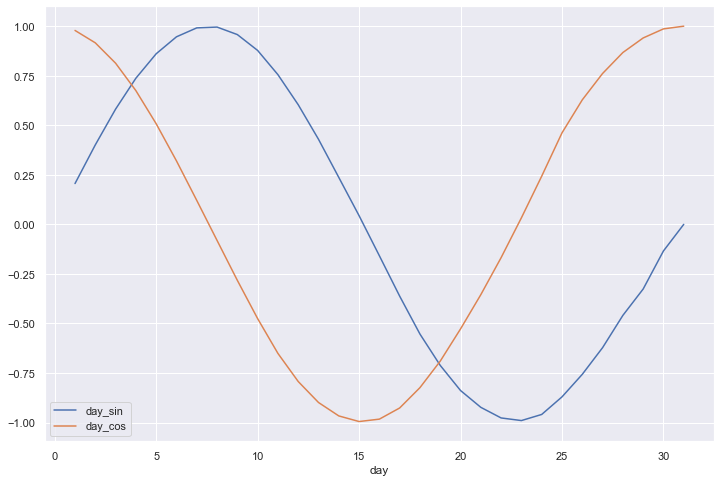

In [85]:
df5[['day','day_sin','day_cos']].groupby('day').mean().plot();

### 5.3.3 Transformation of the target variable

In [86]:
df5['sales'] = np.log1p(df5['sales'])

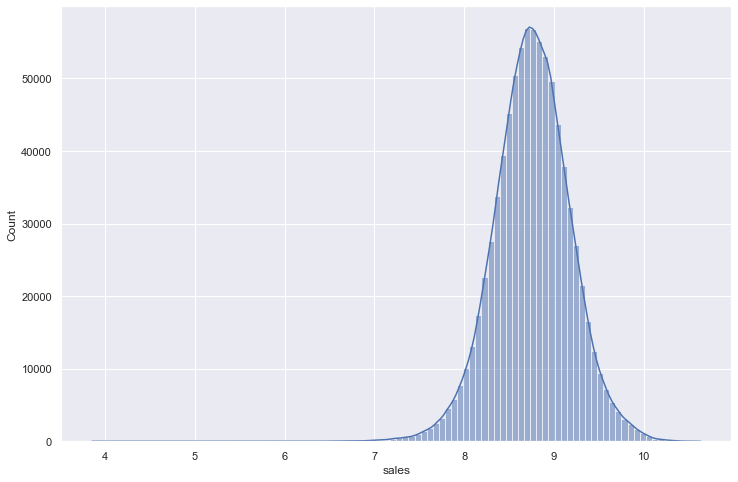

In [87]:
sns.histplot(x = df5['sales'],bins=100,kde = True);

# 6. VARIABLE SELECTION

"The simplest solution is almost always the best." (Occam's Razor)

In [88]:
df6 = df5.copy()

# delete features that were already used to derive others but are now no longer important
cols_drop = ['day','month','week_of_year','day_of_week', 'promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

## 6.1 Split dataframe into training and test dataset

Up to the last 6 weeks it will be the training data and then it will be the test data.

In [89]:
df6[['store','date']].groupby('store').min().value_counts()

date      
2013-01-02    1094
2013-01-01      17
2013-07-05       2
2013-01-19       1
2013-04-12       1
dtype: int64

In [90]:
df6[['store','date']].groupby('store').max().value_counts()

date      
2015-07-31    1113
2015-07-10       1
2015-07-15       1
dtype: int64

Sales almost all started on 01/02/2013 and the last sales record for almost all stores is 07/31/2015. <br>
It is quite reasonable that the 6 week period for the forecast is the one that precedes 07/31/2015. <br>

In [91]:
# subtrair 6 semanas (6 * 7 dias)
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

It is now known that the 6-week period preceding the last sales record started on 06/19/2015. Therefore, this date will be used as a limit for separating the dataset in training and testing.

In [92]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print(f"Training min date: {x_train['date'].min()}")
print(f"Training max date: {x_train['date'].max()}")

print(f"\nTest min date: {x_test['date'].min()}")
print(f"Test max date: {x_test['date'].max()}")

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector
(after running the script once, it is not necessary to run it again - the processing time is long and the result obtained should not vary significantly when changing the seed)

In [93]:
### training and test dataset for Boruta
# x_train_n = x_train.drop(columns = ['date', 'sales'], axis =1).values
# y_train_n = y_train.values.ravel()

### define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

### define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 42).fit(x_train_n, y_train_n)

#cols_selected = boruta.support_.tolist()

### to read the columns chosen by Boruta (instead of numbers), run the lines below
### as x_train still has the 'date' and 'sales' features, I need to remove them to preserve the same column sequence as x_train_n (which is just a vector)
#x_train_fs = x_train.drop(['date','sales'],axis=1)

### the line below selects, based on the variable cols_selected, taken from the 'support_' output of Boruta, which is a vector of True and False for each of the columns
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

### columns not selected
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))



### last run time: 50m 2.73s

### 6.2.1 Best features from Boruta

In [94]:
cols_not_selected_boruta = ['is_promo','month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

cols_selected_boruta = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

### 6.2.2 Update of the table of hypotheses

In [95]:
from tabulate import tabulate

tab = [['Hypotheses', 'Conclusion', 'Relevance', 'Key variable(s)','Boruta'],
       ['H1 - stores with a larger assortment should sell more', 'true','medium','assortment','selected'],
       ['H2 - stores with closer competitors should sell lesss', 'false','low','competition_distance','selected'],
       ['H3 - stores with longer-standing competitors should sell more','false','medium','competition_time_month','selected'],
       ['H4 - stores where products cost less for longer (active promotions) should sell more', 'true','low','promo_time_week','selected'],
       ['H5 - stores with more promotion days should sell more', 'not evaluated', '-','-','-'],
       ['H6 - stores with more extended promotions should sell more','false', 'high','promo and promo2','selected'],
       ['H7 - stores open during Christmas holiday should sell more', 'true', 'high','state_holiday','not selected'],
       ['H8 - stores should sell more over the years','inconclusive','high*','year','not selected'],
       ['H9 - stores should sell more in the second half of the year', 'false', 'medium','month','partially selected (month_cos selected and month_sin discarded)'],
       ['H10 - stores should sell more after the 10th day of each month', 'false', 'high','day','selected'],
       ['H11 - stores should sell less on weekends','true','high','day_of_week','selected'],
       ['H12 - stores should sell less during school holidays', 'false', 'high','school_holiday','not selected'],
       ['H13 - stores that open on Sundays should sell more', 'true','high','day_of_week','selected'],       
      ]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))
print("*although the H8 was inconclusive, I consider the variable 'year' to be highly relevant for the Machine Learning model")

╒══════════════════════════════════════════════════════════════════════════════════════╤═══════════════╤═════════════╤════════════════════════╤═════════════════════════════════════════════════════════════════╕
│ Hypotheses                                                                           │ Conclusion    │ Relevance   │ Key variable(s)        │ Boruta                                                          │
╞══════════════════════════════════════════════════════════════════════════════════════╪═══════════════╪═════════════╪════════════════════════╪═════════════════════════════════════════════════════════════════╡
│ H1 - stores with a larger assortment should sell more                                │ true          │ medium      │ assortment             │ selected                                                        │
├──────────────────────────────────────────────────────────────────────────────────────┼───────────────┼─────────────┼────────────────────────┼─────────────────

<br>
It appears that:
<ul>
<li>2 hypotheses whose key variable I had considered of low relevance for the model ('competition_distance' and 'promo_time_week'), Boruta considered them as important;</li><br>
<li>3 hypotheses whose key variable I had considered of medium relevance for the model ('assortment, 'competition_time_month' and 'month'*), Boruta considered them as important;</li>
<ul>
*'month' Boruta partially selected
</ul><br>

<li>4 hypotheses whose key variable I had considered of high relevance for the model ('promo and promo2', 'day' and 'day_of_week'), Boruta considered them as important;</li><br>
<li>3 hypotheses whose key variable I had considered of high relevance for the model ('state_holiday, 'year' and 'school_holiday'), Boruta did not consider them as important. </li>

A possible explanation for the holiday variables not being considered by Boruta is that such holidays can influence sales during the week as a whole, including the holiday day itself.

Another variable selected by Boruta is the 'store_type'; as it is not clear what each of these types of stores means (the database only provided letters, from 'a' to 'd'), it was not used during the hypothesis validations in the bivariate analysis. However, it was found, during the multivariate analysis of categorical attributes that it has a relatively strong correlation with the 'assortment', which was selected.

Finally, the variable 'is_promo', derived in section 1.5, whose value is 1 (when the sale refers to the month in which the promo started2) or 0 (when the sale occurred in a month other than the start of the promo2) does not seem to have relevance in predicting sales. When revisiting the derivation of this variable, it appears that an analysis error was made: when assigning 'is_promo = 1' only based on the existence of the month of sale in the variable (already discarded in the current dataset) 'promo_interval', there is assignment in the the store's past, even before it first joined the promo2.
The example below, rescued from df1 shows that store 620 started promo2 in week 40 of 2014, starting in Jan, Apr, Jul and Oct. For sales in July 2013 there was no promo2 yet, however it was wrongly assigned the value '1' to 'is_promo'.

In [96]:
df1.loc[799289]

store                                           620
day_of_week                                       1
date                            2013-07-15 00:00:00
sales                                          9732
customers                                       866
open                                              1
promo                                             1
state_holiday                                     0
school_holiday                                    0
store_type                                        d
assortment                                        c
competition_distance                         5440.0
competition_open_since_month                      7
competition_open_since_year                    2013
promo2                                            1
promo2_since_week                                40
promo2_since_year                              2014
promo_interval                      Jan,Apr,Jul,Oct
month_map                                       Jul
is_promo    

With that, 2 important points arise:
<li> Every gateway in the DS project is really important to create a copy of df
<li> the next CRISP cycle will have an update on the value assignment for the variable 'is_promo' to not assign '1' in the store's past, while promo2 didn't exist yet. With that, it is possible that Boruta's analysis for this variable may change.

## 6.3 Manual feature selection

Even though Boruta does not initially consider the variables 'month_sin' and 'week_of_year_sin', as they are complementary to the variables 'month_cos' and 'week_of_year_cos', they will be added to the group of variables selected by Boruta.

In [97]:
cols_not_selected_boruta = ['is_promo','month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

cols_selected_boruta = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']


# add 'month_sin' and 'week_of_year_sin' (initially Boruta left both out)
cols_selected_boruta_with_extra = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                   'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                   'promo_time_week','month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos', 
                                   'day_of_week_sin', 'day_of_week_cos']


# 7. MACHINE LEARNING MODELING

In this section, machine learning modeling begins. <br>
With the exception of the average model, the model will also be cross-validated in its subsection; the explanation about cross validation applied to time series and the summary of the performance of all models is presented in section 7.6.

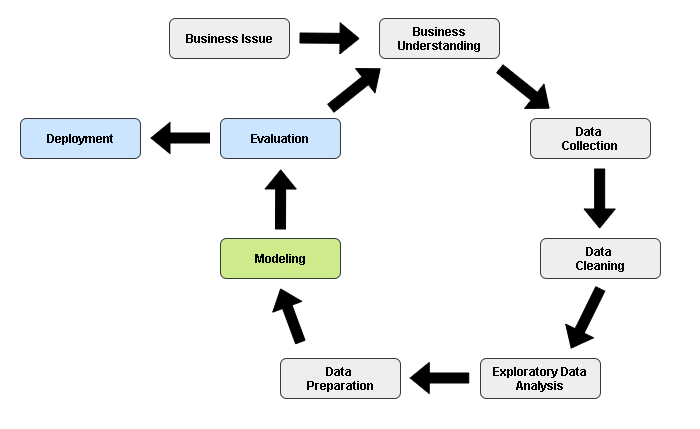

In [98]:
Image("img/crisp3.png")

In [99]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test.set_index('store')['sales']

# add 'date' and 'sales' to consolidate training base that will be used in cross-validation
training_set = x_train[cols_selected_boruta_with_extra + ['date','sales']]
test_set = x_test[cols_selected_boruta_with_extra + ['date','sales']]

# update of training and test variables only with the columns selected by Boruta (without the 'date' and 'sales' columns)
x_train = x_train[cols_selected_boruta_with_extra]
x_test = x_test[cols_selected_boruta_with_extra]

## 7.1. Average model

In [100]:
aux0 = x_train.copy()
aux0['sales'] = y_train.values

aux1 = x_test.copy()

# prediction
aux2 = aux0[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# for manual MAPE calculation, it is important that both series (actual and predicted) have the same index
aux1.set_index('store',inplace=True)
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

# the division between MAPE_manual and MAPE_sklearn was necessary as initially they were resulting in different values.
# after investigating, I found that the index of the two pd.series (y_test and y_hat) were mismatched,
# in this case, y_test skipped the index if the sales record for a certain store did not exist and y_hat did not skip, as it is the result of the merge of aux1 with aux2.
# thus, the math operation was totally distorted.

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Average model,1429.763326,0.216814,0.216814,1939.32873


## 7.2. Linear regression
Linear regression produces linear models that minimize the sum of squared errors between the actual and predicted values of the target variable training data.

In [101]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
y_hat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear regression',np.expm1(y_test),np.expm1(y_hat_lr) )
lr_result

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Linear regression,1866.598482,0.292849,0.292849,2669.488551


It is verified that the linear regression model performs worse than the average. It is a strong indication that the datasert data is not linear but complex enough that we have to use other machine learning algorithms.

### 7.2.1. Linear regression - cross validation 

In [102]:
lr_result_cv = time_series_cross_validation(5, training_set,'Linear regression', lr)
lr_result_cv

,MAE,MAPE_manual,RMSE
Linear regression,2081.69 +/- 295.28,0.3 +/- 0.02,2952.57 +/- 468.48


## 7.3. Regularized linear regression
Regularized linear regression balances the same minimization of sum-of-squares with a penalty term on the size of the coefficients and tends to produce simpler models that are less prone to overfitting.
https://uc-r.github.io/regularized_regression (another explanation, in Portuguese: https://help.alteryx.com/pt-br/current/designer/linear-regression-tool) <br>
The most popular linear regression techniques that use regularization are the so-called Ridge Regression: least absolute shrinkage and selection operator (LASSO) and Elastic Net (source: Python Machine Learning', by Sebastian Raschka, 3rd edition, p. 337)

In [103]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
y_hat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Regularized linear regression',np.expm1(y_test),np.expm1(y_hat_lrr) )
lrr_result

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Regularized linear regression,1891.665962,0.289184,0.289184,2744.049402


### 7.3.1. Regularized linear regression - cross validation

In [104]:
lrr_result_cv = time_series_cross_validation(5, training_set,'Regularized linear regression', lrr)
lrr_result_cv

,MAE,MAPE_manual,RMSE
Regularized linear regression,2116.43 +/- 341.25,0.29 +/- 0.01,3057.75 +/- 503.93


## 7.4. Random forest regressor

In [105]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train,y_train)

# prediction
y_hat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random forest regressor',np.expm1(y_test),np.expm1(y_hat_rf) )
rf_result


,MAE,MAPE_manual,MAPE_sklearn,RMSE
Random forest regressor,664.743449,0.098991,0.098991,972.915465


### 7.4.1. Random forest regressor - cross validation

In [106]:
rf_result_cv = time_series_cross_validation(5, training_set,'Random forest regressor', rf,verbose=True)
rf_result_cv

Kfold: 5...
Kfold: 4...
Kfold: 3...
Kfold: 2...
Kfold: 1...


,MAE,MAPE_manual,RMSE
Random forest regressor,853.71 +/- 257.13,0.12 +/- 0.03,1297.01 +/- 400.11


## 7.5. XGBoost regressor

In [107]:
# XGBoost default parameters
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                       n_estimators = 100,
                       eta = 0.3,
                       max_depth = 6,
                       subsample = 1,
                       colsample_bytree = 1).fit(x_train,y_train)

# prediction
y_hat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
xgb_result


,MAE,MAPE_manual,MAPE_sklearn,RMSE
XGBoost regressor,862.296151,0.129212,0.129212,1236.080808


### 7.5.1. XGBoost regressor - cross validation

In [108]:
xgb_result_cv = time_series_cross_validation(5, training_set,'XGBoost regressor', model_xgb,verbose=True)
xgb_result_cv

Kfold: 5...
Kfold: 4...
Kfold: 3...
Kfold: 2...
Kfold: 1...


,MAE,MAPE_manual,RMSE
XGBoost regressor,1068.62 +/- 165.13,0.15 +/- 0.02,1531.94 +/- 235.94


## 7.6. Model performance

### 7.6.1. Initial performance

In [109]:
model_results = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
model_results.sort_values('RMSE')

,MAE,MAPE_manual,MAPE_sklearn,RMSE
Random forest regressor,664.743449,0.098991,0.098991,972.915465
XGBoost regressor,862.296151,0.129212,0.129212,1236.080808
Average model,1429.763326,0.216814,0.216814,1939.328730
Linear regression,1866.598482,0.292849,0.292849,2669.488551
Regularized linear regression,1891.665962,0.289184,0.289184,2744.049402


For now, it can be seen that the Random forest regressor performed better in relation to the other models. But that doesn't mean it will always be like this. We cannot evaluate ML models just for a slice of the last 6 weeks. It is necessary to perform several slices and test for all, so we will have a more reliable overview of the performance of the models. This is the topic of the next section.

### 7.6.2. Cross-validation performance

The cross-validation method for time series consists of k dataset divisions, where for each of these divisions, there is an increase in the amount of training data, while the test data (validation) remains constant. At each iteration, in a new division of the dataset, the performance of the model is evaluated.
In the case of this work, the test data window (validation) is 6 weeks.
The following figure illustrates this explanation for k = 4.

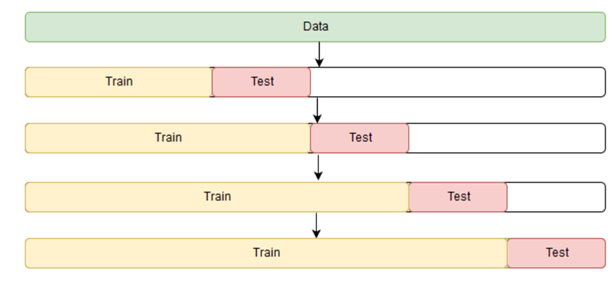

In [110]:
Image('img/ts_cross_validation.png')

In [111]:
model_results_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
model_results_cv.sort_values('RMSE')

,MAE,MAPE_manual,RMSE
Random forest regressor,853.71 +/- 257.13,0.12 +/- 0.03,1297.01 +/- 400.11
XGBoost regressor,1068.62 +/- 165.13,0.15 +/- 0.02,1531.94 +/- 235.94
Linear regression,2081.69 +/- 295.28,0.3 +/- 0.02,2952.57 +/- 468.48
Regularized linear regression,2116.43 +/- 341.25,0.29 +/- 0.01,3057.75 +/- 503.93


Although Random forest performed better at this time, the parameters of the XGBoos model will be fine-tuned; one of the reasons for this is that XXGBoost, when in production, requires much less memory compared to RandomForest.

# 8. HYPERPARAMETER FINE ADJUSTMENT
The goal is to find the set of parameters that maximizes model learning.

The 3 main hyperparameter adjustment strategies are:
1) Random search: <br>
     Advantages: fast, low cost and easy to implement <br>
     Disadvantages: may repeat already tested parameter sets and may not select the best parameter set for the model <br>

2) Grid search: <br>
     Advantage: finding the best combination of parameters that maximize the model's performance (within the set of values available for each of the parameters) <br>
     Disadvantage: time consuming and very costly computationally <br>

3) Bayesian search: <br>
     Advantages: it is able to find parameter values based on past learnings, in addition to being faster than grid search <br>
     Disadvantages: slower than random search
    
Will be implementing random search because it is faster, which is a mandatory feature in this project.

## 8.1 Random search

In [112]:
## session disabled due to high processing time - 7h 42m 32s
## results compiled in the following table

#param = {
#    'n_estimators':  [100, 200, 300, 400, 500]
#    'eta':  [0.01,0.03], 
#    'max_depth': [3,5,9],
#    'subsample': [0.1,0.5,0.7],
#    'colsample_bytree': [0.3,0.7,0.9],
#    'min_child_weight':[3,8,15]
#}


#final_result = pd.DataFrame()
#max_eval = 10


#for i in range(max_eval):
#    # random choice of dictionary values
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)

#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta =  hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight']
#                           )

    ## CV
#    result = time_series_cross_validation(5, training_set,'XGBoost regressor', model_xgb,verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result



Initially the n_estimators, in random search, could vary between [1500, 1700, 2500, 3000, 3500], but the model was too heavy to go into production and a new search was performed, reducing the n_estimators to [100, 200, 300, 400, 500]. All results are shown in the table below.

In [113]:
resultados_finais = {'MAE': ['819.97 +/- 133.17',
                             '1429.38 +/- 155.06',
                             '803.45 +/- 148.08',
                             '1778.07 +/- 205.95',
                             '1314.99 +/- 167.76',
                             '875.68 +/- 153.02',
                             '1434.12 +/- 154.04',
                             '1665.99 +/- 184.88',
                             '1240.11 +/- 140.59',
                             '1286.88 +/- 150.43',
                             '1288.63 +/- 158.53',
                             '1199.55 +/- 146.86',
                             '910.01 +/- 134.73',
                             '1306.34 +/- 148.25',
                             '3080.75 +/- 435.4',
                             '7049.79 +/- 589.86',
                             '7055.46 +/- 595.23',
                             '996.07 +/- 163.0',
                             '7049.77 +/- 589.88',
                             '2035.94 +/- 285.59',
                             '1830.23 +/- 215.46',
                             '1635.67 +/- 195.87',
                             '2013.13 +/- 274.57',
                             '1874.98 +/- 246.91',
                             '972.0 +/- 166.53'],

                        'MAPE_manual': ['0.11 +/- 0.01',
                                        '0.2 +/- 0.01',
                                        '0.11 +/- 0.01',
                                        '0.25 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.12 +/- 0.01',
                                        '0.2 +/- 0.01',
                                        '0.23 +/- 0.01',
                                        '0.17 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.16 +/- 0.01',
                                        '0.13 +/- 0.01',
                                        '0.18 +/- 0.01',
                                        '0.36 +/- 0.02',
                                        '0.95 +/- 0.0',
                                        '0.95 +/- 0.0',
                                        '0.14 +/- 0.01',
                                        '0.95 +/- 0.0',
                                        '0.24 +/- 0.01',
                                        '0.26 +/- 0.01',
                                        '0.23 +/- 0.01',
                                        '0.27 +/- 0.01',
                                        '0.25 +/- 0.01',
                                        '0.13 +/- 0.02'],
                     
                        'RMSE': ['1186.38 +/- 203.43',
                                 '2071.52 +/- 204.79',
                                 '1174.34 +/- 235.99',
                                 '2555.52 +/- 284.45',
                                 '1908.63 +/- 226.44',
                                 '1273.37 +/- 243.37',
                                 '2082.6 +/- 206.7',
                                 '2407.18 +/- 250.03',
                                 '1794.51 +/- 191.54',
                                 '1864.99 +/- 205.9',
                                 '1879.64 +/- 217.16',
                                 '1738.76 +/- 203.14',
                                 '1307.57 +/- 196.17',
                                 '1891.86 +/- 204.63',
                                 '4097.96 +/- 551.4',
                                 '7716.74 +/- 690.72',
                                 '7729.99 +/- 696.1',
                                 '1443.0 +/- 236.73',
                                 '7716.72 +/- 690.74',
                                 '2930.73 +/- 391.74',
                                 '2628.95 +/- 304.43',
                                 '2357.71 +/- 271.9',
                                 '2919.74 +/- 395.95',
                                 '2723.33 +/- 355.11',
                                 '1409.8 +/- 247.92'],
                     
                     'Parameters': ["'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15",
                                    "'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                    "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15",
                                    "'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8",
                                    "'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3",
                                    "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3",
                                    "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                    "'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3",
                                    "'n_estimators': 2500, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15",
                                    "'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8",
                                    "'n_estimators': 100, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 100, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 100, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8",
                                    "'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8",
                                    "'n_estimators': 100, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8",
                                    "'n_estimators': 400, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15",
                                    "'n_estimators': 400, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 400, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8",
                                    "'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15",
                                    "'n_estimators': 500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15",
                                    "'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15"]
                       }

print(tabulate(resultados_finais, headers=['MAE','MAPE','RMSE', 'Hyperparameters'], tablefmt="fancy_grid"))

╒════════════════════╤═══════════════╤════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ MAE                │ MAPE          │ RMSE               │ Hyperparameters                                                                                                      │
╞════════════════════╪═══════════════╪════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ 819.97 +/- 133.17  │ 0.11 +/- 0.01 │ 1186.38 +/- 203.43 │ 'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15 │
├────────────────────┼───────────────┼────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 1429.38 +/- 155.06 │ 0.2 +/- 0.01  │ 2071.52 +/- 204.79 │ 'n_estimators': 3000, 'eta': 0.03, 'max_depth

## 8.2 Final model

In [114]:
## first final model
#param_tuned = {
#    'n_estimators': 1500 ,
#    'eta': 0.03 , 
#    'max_depth': 9,
#    'subsample': 0.7 ,
#    'colsample_bytree': 0.9 ,
#    'min_child_weight': 15
#}
### Performance of this model ->  XGBoost regressor	MAE: 635.853387	MAPE: 0.092987	RMSE: 928.257959

# second final model (after the first one got too heavy in production)
param_tuned = {
    'n_estimators': 500 ,
    'eta': 0.03 , 
    'max_depth': 9,
    'subsample': 0.7 ,
    'colsample_bytree': 0.9 ,
    'min_child_weight': 15
}


model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight'] ).fit(x_train,y_train)

# prediction
y_hat_xgb = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
xgb_result_tuned



,MAE,MAPE_manual,MAPE_sklearn,RMSE
XGBoost regressor,803.556829,0.117662,0.117662,1176.210923


In [115]:
## to save the model (run only once)
#pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

# to load the template
model_xgb_tuned = pickle.load(open('model/model_rossmann.pkl', 'rb'))
y_hat_xgb = model_xgb_tuned.predict(x_test)
xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(y_hat_xgb) )
xgb_result_tuned

,MAE,MAPE_manual,MAPE_sklearn,RMSE
XGBoost regressor,803.556829,0.117662,0.117662,1176.210923


### 8.2.1 Final model tree samples

In [116]:
## to plot the tree drawn by XGBoost

## run the code below once
#import os
#os.environ["PATH"] += os.pathsep + r'caminho para a pasta \Graphviz\bin'

## run the code below (the num_trees parameter is the number of the tree to be drawn)
#import graphviz
#from xgboost import plot_tree
#plot_tree(model_xgb_tuned,num_trees=15)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)

## to save the picture
#fig.savefig('tree15.png')

Below are three samples of trees from the final model. Note that the top node in all of them is the 'promo' feature; as seen in section 4.3.1, the variable with the highest correlation with the target variable is precisely the 'promo'.

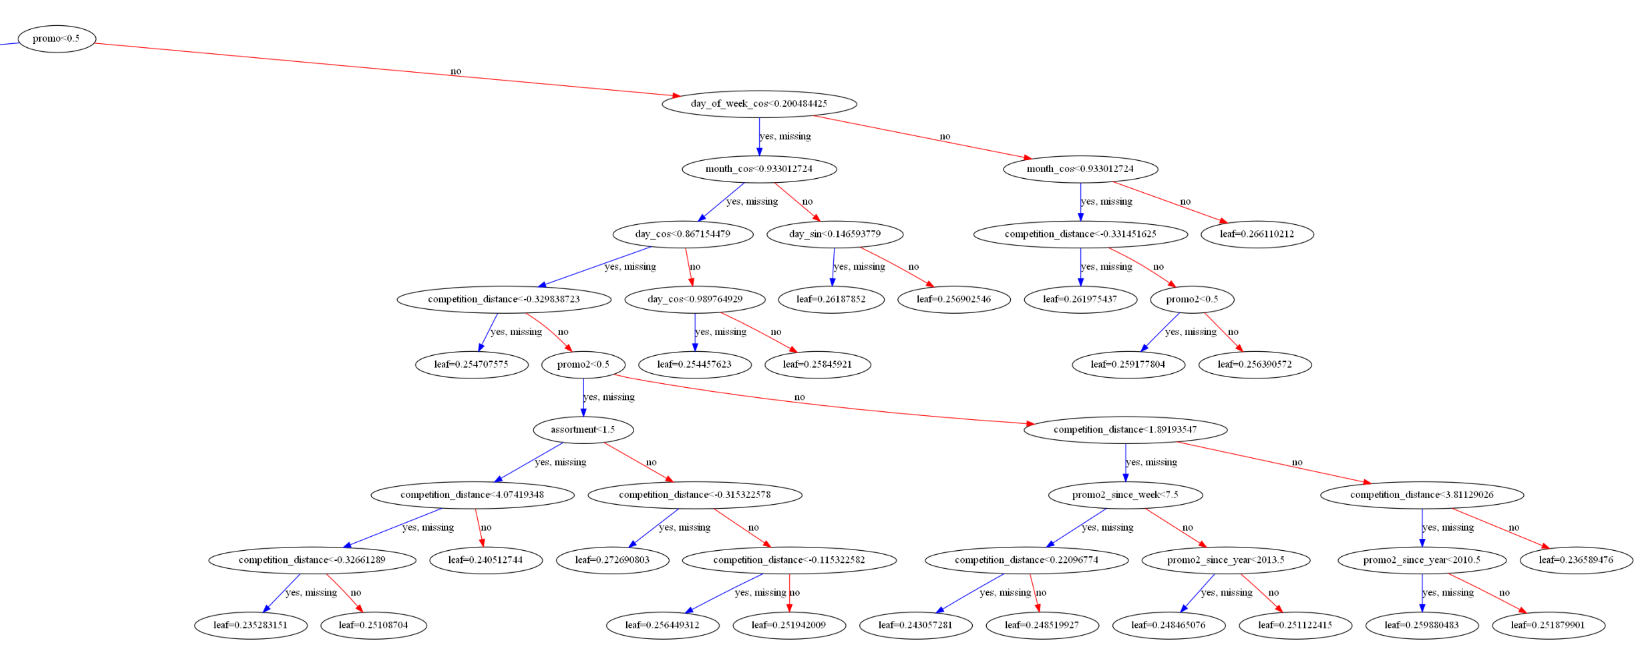

In [117]:
Image("trees/sample_tree0.png")

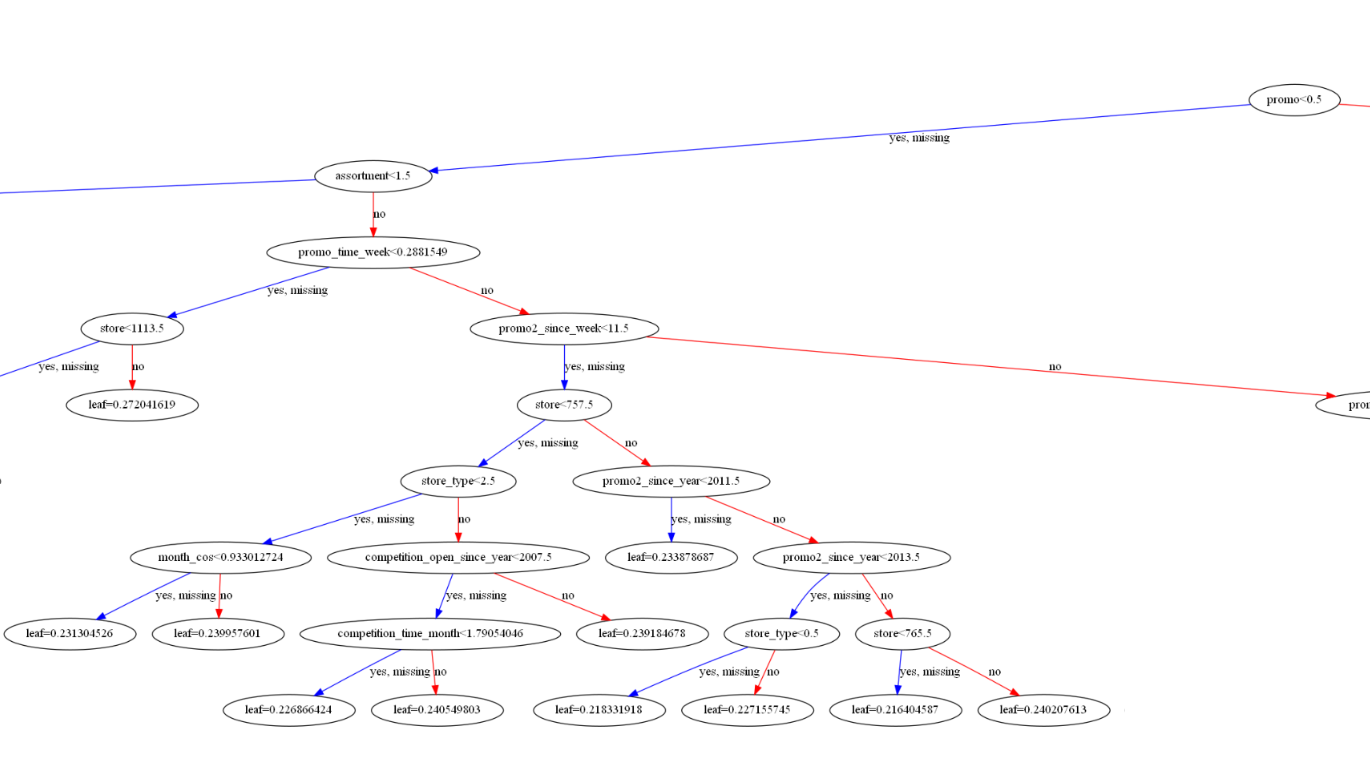

In [118]:
Image("trees/sample_tree1.png")

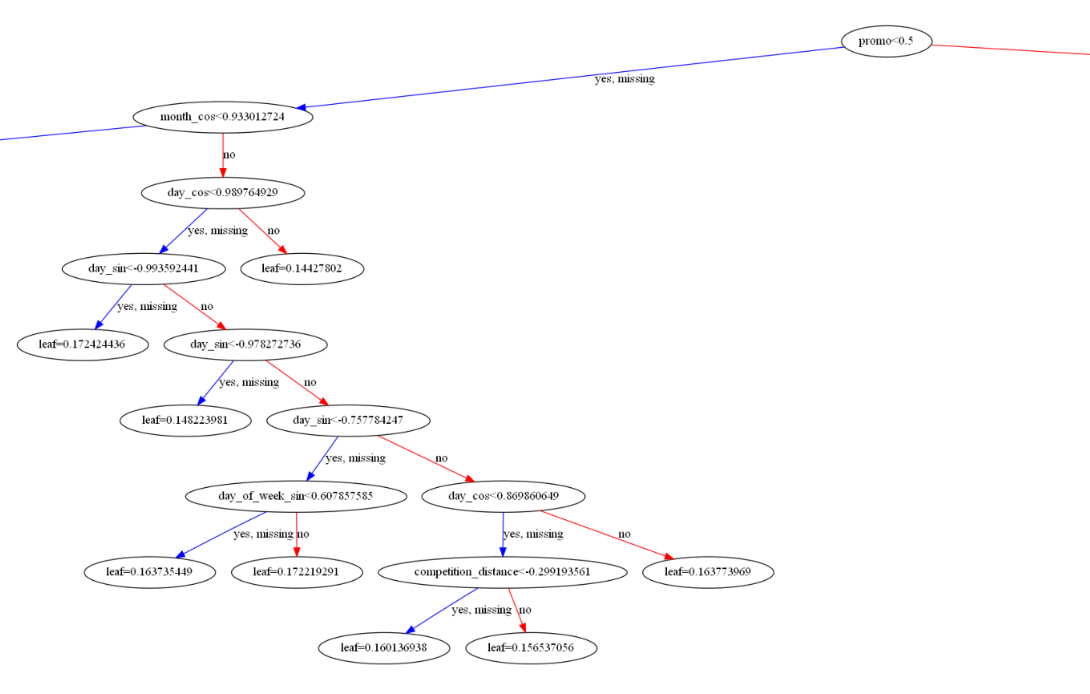

In [119]:
Image("trees/sample_tree15.png")

# 9. TRANSLATION AND ERROR INTERPRETATION
How to understand the performance of the model and tell the CEO how much money this model will bring to the company in the next six weeks?

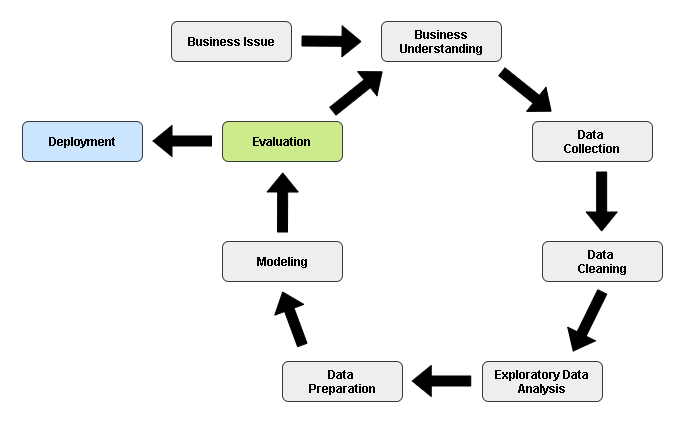

In [120]:
Image("img/crisp4.png")

In [121]:
# obtaining sales data (and forecast) on the original scale
df9 = test_set.copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = (np.expm1(y_hat_xgb))


Regression model performance:

MAE* (Mean Absolute Error) <br>
MAPE* (Mean Absolute Percentage Error) <br>
RMSE* (Root Mean Squared Error) <br>
MPE** (Mean Percentage Error) <br>
*The fundamental difference between MAE/MAPE & RMSE is that thefirst two are not sensitive to outliers, as the error is always absolute, divided by the number of samples. In the third, the error is squared, enhancing its impact; subsequently, it is divided by the sample number before extracting the square root.

** Useful to understand if the model is overestimating or underestimating predictions
<br> <br>

Model performance on the business: <br>
comparison with the status quo: how the sales forecast is currently done vs. the model's forecast proposal
revenue increase

# 9.1 MPE

MPE does not need to be calculated at every model training, unless desired. It is not an error used to evaluate the performance of models, just to report whether the model is tending to underestimate or overestimate the predicted value.

In [122]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(y_hat_xgb))
mpe

-0.006165631948364111

With the value slightly negative, it appears that there is a tendency to overestimate (that is, to predict sales values greater than the real one).

## 9.2 Business performance

In [123]:
# number of days
df9_aux0 = df9[['store','predictions']].groupby('store').count().rename(columns = {'predictions':'days'})

# sum of sales
df9_aux1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE & MAPE
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux3 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# merge: days + sum + MAE + MAPE
df9_aux4 = pd.merge(df9_aux2, df9_aux3, how='inner', on ='store')
df9_aux5 = pd.merge(df9_aux4, df9_aux0, how='inner', on ='store')
df9_1 = pd.merge(df9_aux1, df9_aux5, how='inner', on='store')


# creation of scenarios
df9_1['worst_scenario'] = df9_1['predictions'] - df9_1['days']*df9_1['MAE']
df9_1['best_scenario'] = df9_1['predictions'] + df9_1['days']*df9_1['MAE']

# export MAE to show in production (worst and best scenarios)
df9_1[['store','MAE']].to_csv('data/MAE.csv', index=False)

df9_1.head()


,store,predictions,MAE,MAPE,days,worst_scenario,best_scenario
0,1,169305.703125,308.775496,0.071322,37,157881.009766,180730.396484
1,2,182122.093750,395.432023,0.081463,37,167491.108887,196753.078613
2,3,258817.890625,538.909721,0.075615,37,238878.230957,278757.550293
3,4,338596.250000,944.088880,0.090664,37,303664.961426,373527.538574
4,5,174173.375000,388.329115,0.087439,37,159805.197754,188541.552246


In [124]:
# reorder columns
df9_1 = df9_1[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df9_1.sample(4, random_state = 746)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1059,1060,254987.046875,232567.901855,277406.191895,605.922838,0.085305
573,574,305758.375000,262239.232422,349277.517578,1176.193043,0.118641
324,325,241726.828125,208292.196777,275161.459473,903.638685,0.172171
595,596,175460.156250,159675.087158,191245.225342,426.623489,0.083272


Note that MAPE can fluctuate considerably. To visualize the error oscillation, one point per store can be plotted with its respective MAPE

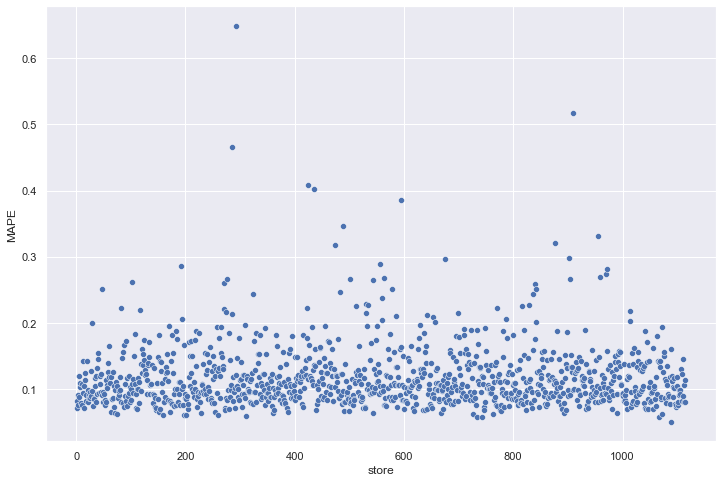

In [125]:
sns.scatterplot(x='store', y='MAPE', data = df9_1);

Important: it is not recommended to make any business decisions based on the current model for stores that have the biggest mistakes; it is recommended, in future CRISP cycles, to understand if there are particularities in these stores and, eventually, to create specific models for them.

## 9.3 Total performance

In [126]:
df_total_performance = pd.DataFrame(df9_1[['predictions', 'worst_scenario','best_scenario']].sum()).rename(columns = {0:'values'})
df_total_performance['values'] = df_total_performance['values'].map('R$ {:,.2f}'.format)
df_total_performance

,values
predictions,"R$ 280,963,392.00"
worst_scenario,"R$ 247,699,333.41"
best_scenario,"R$ 314,227,410.40"


With that, we know the total value of the predictions, considering the worst and the best scenario.

## 9.4 Machine learning performance

To summarize the performance of the machine learning model, a set of four graphs is generated.

In [127]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

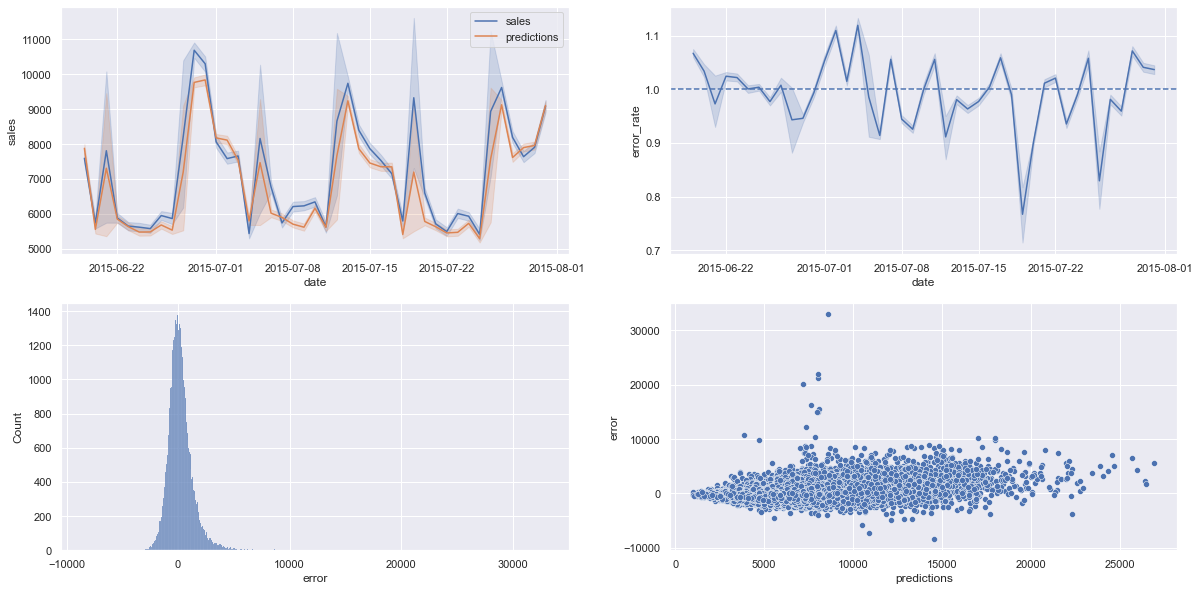

In [128]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'predictions')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.histplot(data = df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = df9['predictions'], y = df9['error']);


This set of graphs summarizes the model's performance. <br>
- The first (top left) shows sales and their respective forecasts, considering all stores. <br>
- The second (top right) shows the error rate, where below 1 is valid for the periods where it underestimated and above 1 is valid for the periods it overestimated. <br>
- The third (bottom left) is the error distribution, which resembles a normal distribution. <br>
- The fourth (bottom right) shows the errors by the value of the predictions; it is noted that the errors for forecasts around R$ 8k tend to be greater, with the largest errors in the model (outliers) being in this range. <br>

The last two graphs are used in residual analysis to help understand the model's weaknesses and what you need to do to increase its performance.

# 10. Model in production
With the performance of the model understood, it can be said that it is ready to complete the first CRISP cycle. At this stage the model will be put into production to make the predictions accessible to any consumer; and then, depending on the feedback received and the priorities of the company, the second CRISP cycle can be carried out or a new project can be started.

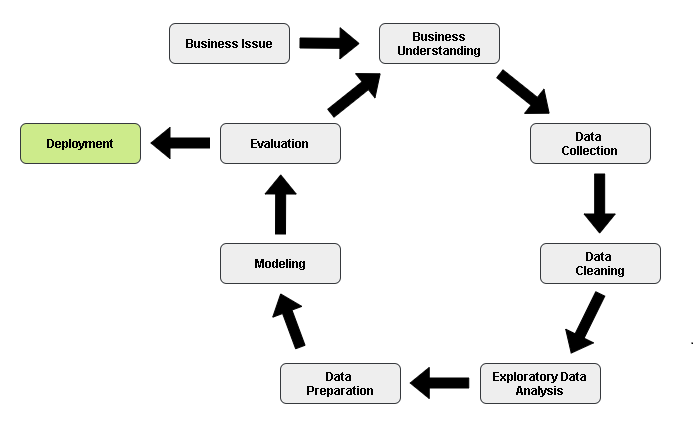

In [129]:
Image("img/crisp5.png")

The architecture of the model in production can be represented as follows:

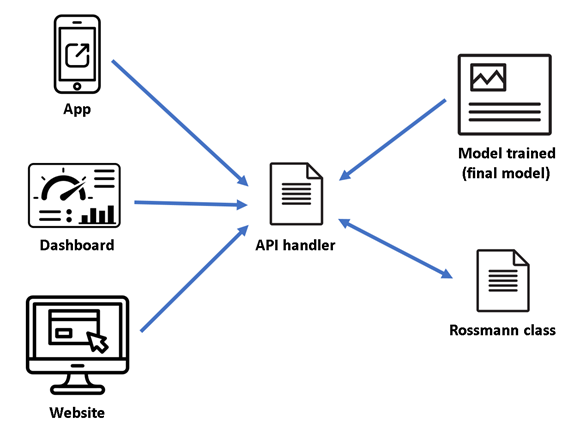

In [130]:
Image("img/schema_prod.png")

The next three subsections bring the scripts for the "Rossmann class", "API handler" and an API test.

## 10.1. Rossmann class

In [128]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from sklearn.metrics import mean_absolute_error

class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        
        # read scaler for use in production
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        
        # read scaler for use in production
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        
        # read scaler for use in production
        self.promo_time_week_scaler =  pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        
        # read scaler for use in production
        self.year_scaler =  pickle.load(open(self.home_path + 'parameter/year_scaler.pkl','rb'))
        
        # read scaler for use in production
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self,df1):
        # the same previously written sections are used for cleaning new data
        
        ## 1.1. Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,cols_old))
        df1.columns = cols_new
            
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
            
            
        ## 1.5. Fillout NA
        # competition_distance
        df1["competition_distance"] = df1["competition_distance"].fillna(200000)

        # competition_open_since_month
        x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
        df1["competition_open_since_month"] = df1.apply(x, axis=1)

        # competition_open_since_year
        x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
        df1["competition_open_since_year"] = df1.apply(x, axis=1)

        # promo2_since_week
        x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
        df1["promo2_since_week"] = df1.apply(x, axis=1)

        # promo2_since_year
        x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
        df1["promo2_since_year"] = df1.apply(x, axis=1)

        # promo_interval
        df1["promo_interval"].fillna(0, inplace = True)

        # month_map
        month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
        df1["month_map"] = df1["date"].dt.month.map(month_map)

        # is_promo
        df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)


        ## 1.6. Change Types
        df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
        df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
        df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
        df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

        return df1
        
    def feature_engineering(self,df2):
        
        # 2.3. Feature Engineering

        # year
        df2["year"] = df2["date"].dt.year
        
        # month
        df2["month"] = df2["date"].dt.month
        
        # day
        df2["day"] = df2["date"].dt.day
        
        # week of year
        df2["week_of_year"] = df2["date"].dt.isocalendar().week
        
        # year week
        df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

        # competition_time_month
        df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
        df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

        # promo_time_week
        df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
        df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
        df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})
        
        # state holiday
        df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})
        
        # 3.1. Line filtering
        df2 = df2[df2['open'] != 0]
        
        # 3.2. Selection of columns
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self,df5):
    
        # 5.2 Rescaling
        # originally the 'week_of_year' series is as type UInt32; the conversion takes place.
        df5['week_of_year'] = df5['week_of_year'].astype(np.int64)

        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)


        # 5.3.1 Non-cyclical features encoding
        # state_holiday
        df5 = pd.get_dummies(data=df5,prefix='state_holiday',columns=['state_holiday'])

        # store_type
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        # assortment
        assortment_dict = {'basic':1, 'extra':2, 'extended':3} 
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # 5.3.2 Cyclical features encoding
        #month
        df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2 * np.pi / 12)))


        #day
        max_days_month = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
        df5['max_days_month'] = df5['month'].map(max_days_month)

        x = lambda x: np.sin(x['day'] * (2 * np.pi / x['max_days_month']))
        df5['day_sin'] = df5.apply(x, axis=1)

        x = lambda x: np.cos(x['day'] * (2 * np.pi / x['max_days_month']))
        df5['day_cos'] = df5.apply(x, axis=1)

        df5.drop(columns='max_days_month',inplace=True)


        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))
        
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week','month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos', 
                         'day_of_week_sin', 'day_of_week_cos']

        return df5[cols_selected]
    
    def get_prediction(self,model,original_data, test_data):
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        # load MAE
        df_mae = pd.read_csv('data/MAE.csv')
        
        # merge with MAE
        df_response_with_MAE = pd.merge(original_data, df_mae, how='left', on='store')
        
        # scenarios
        df_response_with_MAE['best_scenario'] = df_response_with_MAE['prediction'] + df_response_with_MAE['MAE']
        df_response_with_MAE['worst_scenario'] = df_response_with_MAE['prediction'] - df_response_with_MAE['MAE']
        
        
        return df_response_with_MAE.to_json(orient='records', date_format = 'iso')

## 10.2. API handler

In [427]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# load model
model = pickle.load(open('model/model_rossmann.pkl', 'rb'))


app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        # if json is unique (ie a dictionary)
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        # if not unique, create dataframe considering json keys
        else:       
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # instantiate the Rossmann class
        pipeline = Rossmann()
        
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)       
       
        return df_response
        
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
	port = os.environ.get('PORT',5000)
	app.run(host = '0.0.0.0', port=port)


## 10.3. API tester

In [131]:
import requests

In [132]:
# load test dataset
df10 = pd.read_csv(r'C:\Users\RNFAVAR.EMBAD.000\Documents\NEO DIPAS\Ciencia de Dados na Embraer\repos\ds_em_producao\data\test.csv')
df_test = pd.merge(df10,df_store_raw, how='left', on = 'Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([50,100,200, 1060, 574, 325])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] # some 'Open' values are null; these rows cannot be used
df_test = df_test.drop(columns = ['Id'])

In [133]:
# convert dataframe to a json list
data = json.dumps(df_test.to_dict(orient = 'records'))

In [134]:
# API call
# open terminal and run api handler (python handler.py)
#url = 'http://192.168.15.7:5000/rossmann/predict'
url = 'https://rossmann-model-predictions.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'} # type of requisition
data = data

r = requests.post(url=url,data=data, headers = header)
print(f'Status code {r.status_code}')

Status code 200


In [135]:
df_resp = pd.DataFrame(r.json())
df_resp.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction,MAE,best_scenario,worst_scenario
0,50,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,6260.0,11,2009,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2009-11-01T00:00:00.000Z,71,2015-09-14T00:00:00.000Z,0,4957.169434,422.398352,5379.567785,4534.771082
1,100,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,17930.0,9,2015,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,7115.467773,698.719344,7814.187117,6416.748430
2,200,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1650.0,10,2000,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2000-10-01T00:00:00.000Z,182,2015-09-14T00:00:00.000Z,0,7639.339844,706.388408,8345.728252,6932.951436
3,325,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,350.0,3,2011,1,22,2011,"Feb,May,Aug,Nov",Sept,0,2015,9,17,38,2015-37,2011-03-01T00:00:00.000Z,55,2011-05-23T00:00:00.000Z,225,7269.827637,903.638685,8173.466322,6366.188952
4,574,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4400.0,9,2015,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,8270.543945,1176.193043,9446.736988,7094.350903


In [137]:
df_pred = df_resp[['store','prediction','worst_scenario','best_scenario']].groupby('store').sum().reset_index()

for i in range(len(df_pred)):
     print("Store number {} will sell R$ {:,.2f} (may vary between R$ {:,.2f} and R$ {:,.2f}) in the next 6 weeeks.".format(df_pred.loc[i, 'store'],
                                                                                                                            df_pred.loc[i, 'prediction'],
                                                                                                                            df_pred.loc[i, 'worst_scenario'],
                                                                                                                            df_pred.loc[i, 'best_scenario']))

Store number 50 will sell R$ 184,253.18 (may vary between R$ 166,934.85 and R$ 201,571.52) in the next 6 weeeks.
Store number 100 will sell R$ 294,503.66 (may vary between R$ 266,554.89 and R$ 322,452.43) in the next 6 weeeks.
Store number 200 will sell R$ 299,045.63 (may vary between R$ 270,083.71 and R$ 328,007.56) in the next 6 weeeks.
Store number 325 will sell R$ 268,032.33 (may vary between R$ 230,983.15 and R$ 305,081.52) in the next 6 weeeks.
Store number 574 will sell R$ 326,369.06 (may vary between R$ 278,145.15 and R$ 374,592.98) in the next 6 weeeks.
Store number 1060 will sell R$ 276,553.21 (may vary between R$ 251,710.38 and R$ 301,396.05) in the next 6 weeeks.


# 11. Future CRISP cycles

If necessary, work on another CRISP cycle to:
- use the 'customers' feature
     - to do so, develop a customer forecasting project, using new features (if possible to be obtained), such as 'demographic density in the store's region', 'population/number of stores in the city', 'tourist city or not' , 'weather of the day' etc. Also, some features already available may be more appropriate for this project, such as 'closest competitor', "promotions" etc. Such features impact the number of customers more than the sales themselves. But in this project, we encapsulate all features to forecast sales, only. On the other hand, features such as "holiday" do not impact the number of customers, as all customers will be on the same holiday. The holiday impacts buying behavior, that is, sales directly. With the customer forecast project completed, the data obtained can be fed into the sales forecast project. 
<br>


- if it is necessary to increase the accuracy of the sales forecast for a specific store (mainly for those whose forecast resulted in a high MAPE value), a model for that store can be created.

- in section 5.2, rescale the variables 'promo2_since_week', 'promo2_since_year' and 'competition_open_since_year'

- in section 6.1, if necessary, the stores that ended sales on 07/10 and 07/15 (one for each date) can be studied and trained separately from the others.

- in section 6.2.2, a a new hypothesis can be created: "Stores should sell more during the holiday week", whose key variable is the 'week_of_year', already selected by the Boruta.

- in section 6.2.2, as explained, improve the assignment of the is_promo feature during section 1.5
     